# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 0. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 1. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'gamma_input': 6.3831
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 6.3831|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05-00': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
}

n_neurons_dict = {
    '2023-03-15_11-05-00': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")

readout_output_sample

tensor([[ 0.0002, -0.0027, -0.0018,  ...,  0.0002,  0.0072,  0.0023],
        [ 0.0002, -0.0027, -0.0018,  ...,  0.0002,  0.0072,  0.0023],
        [ 0.0002, -0.0027, -0.0018,  ...,  0.0002,  0.0072,  0.0023],
        ...,
        [ 0.0002, -0.0027, -0.0018,  ...,  0.0002,  0.0072,  0.0023],
        [ 0.0002, -0.0027, -0.0018,  ...,  0.0002,  0.0072,  0.0023],
        [ 0.0002, -0.0027, -0.0018,  ...,  0.0002,  0.0072,  0.0023]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'

# 1. Load the images and responses
training_images = np.load(os.path.join(TRAINING_DATA_DIR, 'training_images_2023-03-15_11-05.npy'))
training_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'training_responses_2023-03-15_11-05.npy'))

test_images = np.load(os.path.join(TRAINING_DATA_DIR, 'test_images_2023-03-15_11-05.npy'))
test_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'test_responses_2023-03-15_11-05.npy'))

training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
training_images = torch.from_numpy(training_images).float()
test_images = torch.from_numpy(test_images).float()

training_responses = torch.from_numpy(training_responses).float()
test_responses = torch.from_numpy(test_responses).float()

# 3. Zip training and test
training_data = list(zip(training_images, training_responses))
test_data = list(zip(test_images, test_responses))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

# 4. Load sample batch
images_batch, responses_batch = next(iter(train_dataloader))

# 5. Validate shape and types
training_images.shape, test_images.shape, images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([8388, 1, 36, 22]),
 torch.Size([931, 1, 36, 22]),
 torch.Size([16, 1, 36, 22]),
 torch.Size([16, 453]),
 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 5,
    'hidden_kern': 3,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    # 'gamma_input': 6.3831
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([16, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([16, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Test the factorized**

In [24]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([16, 453]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [25]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [26]:
model = GeneralizedEncoderBase(
    core,
    factorized_readout,
    elu=True
)

In [27]:
trained_model, training_history = simplified_trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=100,
    patience=15 # For the early stopping
)

Epoch 1/100 (Train):   0%|                                                                               | 0/525 [00:00<?, ?it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 0.9999995231628418 0.9677347540855408 1.0459868907928467
-----
loss:  tensor(6.9593, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   0%|▏                                                                      | 1/525 [00:00<02:24,  3.63it/s]

PoissonNLLLoss()
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 1.0425957441329956 0.13188815116882324 3.155488967895508
-----
loss:  tensor(7.0582, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 1.2268108129501343 0.01548469066619873 7.67911958694458
-----
loss:  tensor(4.8227, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 1.368046760559082 0.0002637505531311035 8.198624610900879
-----
loss:  tensor(6.0745, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1638295650482178 0.0 109.92671203613281
predictions mean/min/max: 1.32660973072052 0.0011095404624938965 7.150008201599121
-----
loss:  tensor(7.2752, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   1%|▉                                                                      | 7/525 [00:00<00:24, 21.51it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1595003604888916 0.0 89.9400405883789
predictions mean/min/max: 1.4433234930038452 0.00043767690658569336 10.10588550567627
-----
loss:  tensor(7.1174, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.343909502029419 0.0 159.89340209960938
predictions mean/min/max: 1.5574209690093994 0.00034731626510620117 9.077425003051758
-----
loss:  tensor(7.3958, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1088342666625977 0.0 89.91008758544922
predictions mean/min/max: 1.636906623840332 0.0001462697982788086 9.536295890808105
-----
loss:  tensor(4.7546, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9041686058044434 0.0 139.5812530517578
predictions mean/min/max: 1.5700050592422485 7.987022399902344e-06 19.955604553222656
-----
loss:  tensor(8.6584, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.816639423370

Epoch 1/100 (Train):   2%|█▋                                                                    | 13/525 [00:00<00:15, 32.82it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.006004810333252 6.556510925292969e-06 12.992955207824707
-----
loss:  tensor(6.6990, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.139936685562134 1.7404556274414062e-05 13.0973482131958
-----
loss:  tensor(5.2417, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.418259859085083 0.0 169.60426330566406
predictions mean/min/max: 2.237042188644409 9.999999974752427e-07 16.188671112060547
-----
loss:  tensor(6.2427, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.220965623855591 0.0 99.56853485107422
predictions mean/min/max: 2.357872486114502 2.562999725341797e-05 22.132492065429688
-----
loss:  tensor(5.6031, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/100 (Train):   4%|██▌                                                                   | 19/525 [00:00<00:12, 39.57it/s]

responses mean/min/max: 2.9574809074401855 0.0 120.1201171875
predictions mean/min/max: 2.4783835411071777 9.999999974752427e-07 15.370287895202637
-----
loss:  tensor(5.3929, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0246291160583496 0.0 139.81358337402344
predictions mean/min/max: 2.594567060470581 3.159046173095703e-06 19.088016510009766
-----
loss:  tensor(5.4403, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.711289644241333 0.0 149.7504119873047
predictions mean/min/max: 2.7100017070770264 1.1920928955078125e-06 17.571537017822266
-----
loss:  tensor(5.0925, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9228768348693848 0.0 119.8402099609375
predictions mean/min/max: 2.6674654483795166 9.999999974752427e-07 25.750268936157227
-----
loss:  tensor(5.4690, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2682008743286133 0.0 89.88015

Epoch 1/100 (Train):   5%|███▏                                                                  | 24/525 [00:00<00:11, 42.09it/s]

tensor(5.2362, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6242098808288574 0.0 199.60079956054688
predictions mean/min/max: 3.1813056468963623 9.999999974752427e-07 31.335378646850586
-----
loss:  tensor(7.2955, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296851396560669 0.0 120.0400161743164
predictions mean/min/max: 3.140752077102661 6.973743438720703e-06 23.768653869628906
-----
loss:  tensor(6.0868, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   6%|███▊                                                                  | 29/525 [00:00<00:11, 43.51it/s]

PoissonNLLLoss()
responses mean/min/max: 2.2412071228027344 0.0 119.8402099609375
predictions mean/min/max: 3.1392760276794434 5.245208740234375e-06 24.9432373046875
-----
loss:  tensor(4.4869, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.063704490661621 0.0 159.62753295898438
predictions mean/min/max: 3.078561305999756 9.999999974752427e-07 33.474639892578125
-----
loss:  tensor(6.7523, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.336756706237793 0.0 110.110107421875
predictions mean/min/max: 3.098531484603882 9.999999974752427e-07 28.420547485351562
-----
loss:  tensor(5.3853, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5207865238189697 0.0 149.70059204101562
predictions mean/min/max: 3.1434214115142822 9.999999974752427e-07 20.11458396911621
-----
loss:  tensor(5.8806, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.503217458724975

Epoch 1/100 (Train):   7%|████▋                                                                 | 35/525 [00:00<00:10, 45.67it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6582982540130615 0.0 199.86676025390625
predictions mean/min/max: 3.187227249145508 9.999999974752427e-07 24.643030166625977
-----
loss:  tensor(4.5043, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.644589900970459 0.0 99.83361053466797
predictions mean/min/max: 3.2387309074401855 1.0013580322265625e-05 21.10328483581543
-----
loss:  tensor(5.0462, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.383871555328369 0.0 149.8501434326172
predictions mean/min/max: 3.1989195346832275 2.8014183044433594e-06 25.91354751586914
-----
loss:  tensor(5.6182, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):   8%|█████▎                                                                | 40/525 [00:01<00:10, 44.54it/s]

PoissonNLLLoss()
responses mean/min/max: 2.4881927967071533 0.0 140.0
predictions mean/min/max: 3.217831611633301 1.3053417205810547e-05 23.278305053710938
-----
loss:  tensor(4.5795, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.763470411300659 0.0 149.45201110839844
predictions mean/min/max: 3.230802297592163 9.999999974752427e-07 21.078563690185547
-----
loss:  tensor(5.9405, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.131312608718872 0.0 199.40179443359375
predictions mean/min/max: 3.14272141456604 9.999999974752427e-07 28.97934913635254
-----
loss:  tensor(5.4550, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9061272144317627 0.0 89.88015747070312
predictions mean/min/max: 3.335890531539917 9.999999974752427e-07 32.70704650878906
-----
loss:  tensor(5.0290, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.53216290473938 0.0 119.8003

Epoch 1/100 (Train):   9%|██████                                                                | 45/525 [00:01<00:10, 46.03it/s]

responses mean/min/max: 3.529517889022827 0.0 119.48224639892578
predictions mean/min/max: 3.310945510864258 9.999999974752427e-07 28.306459426879883
-----
loss:  tensor(5.7163, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6501388549804688 0.0 169.71713256835938
predictions mean/min/max: 3.2273507118225098 9.999999974752427e-07 29.266178131103516
-----
loss:  tensor(5.5581, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 3.2121360301971436 9.999999974752427e-07 34.57431411743164
-----
loss:  tensor(5.4025, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/100 (Train):  10%|██████▊                                                               | 51/525 [00:01<00:09, 48.08it/s]

responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 3.241698741912842 9.999999974752427e-07 29.486543655395508
-----
loss:  tensor(4.6920, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8499245643615723 0.0 129.87013244628906
predictions mean/min/max: 3.405757427215576 9.999999974752427e-07 26.192874908447266
-----
loss:  tensor(5.7779, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5142250061035156 0.0 140.2337188720703
predictions mean/min/max: 3.1412081718444824 9.999999974752427e-07 31.648006439208984
-----
loss:  tensor(4.6292, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8249855041503906 0.0 179.8800811767578
predictions mean/min/max: 3.101106882095337 9.999999974752427e-07 34.605709075927734
-----
loss:  tensor(4.9381, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.606348991394043 0.0 99.76721

Epoch 1/100 (Train):  12%|████████▎                                                             | 62/525 [00:01<00:09, 48.44it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3769407272338867 0.0 199.60079956054688
predictions mean/min/max: 2.8105931282043457 5.602836608886719e-06 33.59871292114258
-----
loss:  tensor(5.4495, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.417120933532715 0.0 119.80033111572266
predictions mean/min/max: 3.139472723007202 9.999999974752427e-07 34.829254150390625
-----
loss:  tensor(5.3305, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6002211570739746 0.0 109.89010620117188
predictions mean/min/max: 3.116732597351074 9.999999974752427e-07 31.550283432006836
-----
loss:  tensor(4.3974, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7767536640167236 0.0 80.0533676147461
predictions mean/min/max: 3.146604061126709 9.999999974752427e-07 31.60179901123047
-----
loss:  tensor(4.7187, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.3015456199646

Epoch 1/100 (Train):  13%|█████████                                                             | 68/525 [00:01<00:09, 50.02it/s]

PoissonNLLLoss()
responses mean/min/max: 2.783827543258667 0.0 139.86013793945312
predictions mean/min/max: 3.421840190887451 9.999999974752427e-07 29.41417694091797
-----
loss:  tensor(4.6070, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6814591884613037 0.0 149.65081787109375
predictions mean/min/max: 3.4496958255767822 9.999999974752427e-07 27.26702880859375
-----
loss:  tensor(5.5866, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.225196838378906 0.0 189.74700927734375
predictions mean/min/max: 3.336233377456665 9.999999974752427e-07 32.56910705566406
-----
loss:  tensor(6.1453, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2841155529022217 0.0 149.7504119873047
predictions mean/min/max: 3.2779128551483154 2.1457672119140625e-06 25.52117919921875
-----
loss:  tensor(5.2605, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3311898708343

Epoch 1/100 (Train):  14%|█████████▊                                                            | 74/525 [00:01<00:08, 50.83it/s]

PoissonNLLLoss()
responses mean/min/max: 2.4255263805389404 0.0 129.826904296875
predictions mean/min/max: 3.614063024520874 8.761882781982422e-06 31.371288299560547
-----
loss:  tensor(4.5167, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9137165546417236 0.0 110.14686584472656
predictions mean/min/max: 3.2489027976989746 3.516674041748047e-06 30.086807250976562
-----
loss:  tensor(4.6556, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4902820587158203 0.0 149.7504119873047
predictions mean/min/max: 3.635305404663086 1.1742115020751953e-05 43.89084243774414
-----
loss:  tensor(5.3083, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0542619228363037 0.0 129.826904296875
predictions mean/min/max: 3.3689324855804443 0.00011086463928222656 30.161527633666992
-----
loss:  tensor(4.8527, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  15%|██████████▋                                                           | 80/525 [00:01<00:08, 51.90it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2502222061157227 0.0 144.83102416992188
predictions mean/min/max: 3.365100145339966 0.00025326013565063477 36.867549896240234
-----
loss:  tensor(5.0230, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.9234446287155151 0.0 99.83361053466797
predictions mean/min/max: 3.2980990409851074 0.00027829408645629883 27.294178009033203
-----
loss:  tensor(4.0485, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.046682119369507 0.0 199.66722106933594
predictions mean/min/max: 3.1386444568634033 5.030632019042969e-05 32.40248107910156
-----
loss:  tensor(4.8689, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.651304244995117 0.0 119.8402099609375
predictions mean/min/max: 3.3876123428344727 7.414817810058594e-05 28.08692741394043
-----
loss:  tensor(5.4467, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2490401268

Epoch 1/100 (Train):  16%|███████████▍                                                          | 86/525 [00:01<00:08, 52.46it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3749682903289795 0.0 109.92671203613281
predictions mean/min/max: 2.850261926651001 0.0003600120544433594 36.107147216796875
-----
loss:  tensor(5.3791, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2323663234710693 0.0 119.96001434326172
predictions mean/min/max: 2.9149136543273926 0.0002886652946472168 29.09575843811035
-----
loss:  tensor(4.1894, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 2.779970169067383 8.612871170043945e-05 34.594993591308594
-----
loss:  tensor(4.8569, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  18%|████████████▎                                                         | 92/525 [00:02<00:08, 51.43it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4102046489715576 0.0 129.87013244628906
predictions mean/min/max: 2.835010051727295 0.00026047229766845703 30.574424743652344
-----
loss:  tensor(5.5902, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.17523193359375 0.0 129.7405242919922
predictions mean/min/max: 2.872039556503296 0.0001062154769897461 28.816938400268555
-----
loss:  tensor(6.3616, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0872995853424072 0.0 129.826904296875
predictions mean/min/max: 2.864548683166504 0.00014162063598632812 28.56862449645996
-----
loss:  tensor(5.0001, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.633484125137329 0.0 110.07337951660156
predictions mean/min/max: 3.015218734741211 1.9311904907226562e-05 32.467132568359375
-----
loss:  tensor(4.5277, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7640130519866

Epoch 1/100 (Train):  19%|█████████████                                                         | 98/525 [00:02<00:08, 52.12it/s]

tensor(4.8645, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.055422067642212 0.0 149.9000701904297
predictions mean/min/max: 3.0426177978515625 1.728534698486328e-05 29.485626220703125
-----
loss:  tensor(5.2207, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296902656555176 0.0 140.14013671875
predictions mean/min/max: 3.146301746368408 4.5299530029296875e-06 36.91947937011719
-----
loss:  tensor(5.0080, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.006019353866577 0.0 139.90672302246094
predictions mean/min/max: 3.0451557636260986 4.2498111724853516e-05 28.22787094116211
-----
loss:  tensor(4.9303, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  20%|█████████████▋                                                       | 104/525 [00:02<00:08, 51.28it/s]

PoissonNLLLoss()
responses mean/min/max: 3.382957696914673 0.0 159.73377990722656
predictions mean/min/max: 3.0262434482574463 0.0001099705696105957 31.504878997802734
-----
loss:  tensor(5.5746, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6481311321258545 0.0 100.0
predictions mean/min/max: 3.1103358268737793 3.892183303833008e-05 33.96877670288086
-----
loss:  tensor(4.4042, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8327560424804688 0.0 180.30050659179688
predictions mean/min/max: 3.162872552871704 2.187490463256836e-05 36.05424118041992
-----
loss:  tensor(5.8829, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.720057964324951 0.0 89.85025024414062
predictions mean/min/max: 3.2049450874328613 3.331899642944336e-05 31.132049560546875
-----
loss:  tensor(4.5532, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.099470376968384 0.0 139.

Epoch 1/100 (Train):  22%|███████████████▏                                                     | 116/525 [00:02<00:07, 52.28it/s]

responses mean/min/max: 3.0221917629241943 0.0 110.18363952636719
predictions mean/min/max: 3.239603281021118 0.0002218484878540039 29.46253776550293
-----
loss:  tensor(4.8681, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4589338302612305 0.0 139.67408752441406
predictions mean/min/max: 3.2734501361846924 0.00015401840209960938 30.52594566345215
-----
loss:  tensor(5.3630, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1910219192504883 0.0 119.8402099609375
predictions mean/min/max: 3.27022647857666 0.00022989511489868164 35.95901870727539
-----
loss:  tensor(4.6799, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.058100700378418 0.0 170.170166015625
predictions mean/min/max: 3.2924931049346924 0.00010293722152709961 53.188228607177734
-----
loss:  tensor(4.8257, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.586507797241211 0.0 219.92669

Epoch 1/100 (Train):  23%|████████████████                                                     | 122/525 [00:02<00:07, 51.17it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0803794860839844 0.0 149.80026245117188
predictions mean/min/max: 3.31999135017395 9.08970832824707e-05 46.3182373046875
-----
loss:  tensor(5.0077, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.61008358001709 0.0 139.48854064941406
predictions mean/min/max: 3.1788065433502197 0.0003135800361633301 38.256004333496094
-----
loss:  tensor(6.8431, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5404233932495117 0.0 100.10009765625
predictions mean/min/max: 3.267756700515747 0.0001316070556640625 42.47636032104492
-----
loss:  tensor(5.7217, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.968034505844116 0.0 129.6542510986328
predictions mean/min/max: 3.226494073867798 0.00033992528915405273 37.74970245361328
-----
loss:  tensor(4.7441, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9926693439483643 0.0

Epoch 1/100 (Train):  24%|████████████████▊                                                    | 128/525 [00:02<00:07, 52.05it/s]

tensor(5.0846, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3504798412323 0.0 120.0400161743164
predictions mean/min/max: 3.0702731609344482 7.808208465576172e-06 38.78662109375
-----
loss:  tensor(4.7996, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.011676073074341 0.0 89.97000885009766
predictions mean/min/max: 3.0346426963806152 7.510185241699219e-06 39.65108108520508
-----
loss:  tensor(4.7595, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predictions mean/min/max: 3.0178840160369873 2.574920654296875e-05 35.69099807739258
-----
loss:  tensor(4.9334, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  26%|█████████████████▌                                                   | 134/525 [00:02<00:07, 50.76it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8365817070007324 0.0 169.71713256835938
predictions mean/min/max: 3.010521411895752 1.2993812561035156e-05 39.756988525390625
-----
loss:  tensor(5.7433, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.121422290802002 0.0 99.93338012695312
predictions mean/min/max: 3.1797430515289307 4.0411949157714844e-05 33.248634338378906
-----
loss:  tensor(4.7486, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.284454822540283 0.0 129.95668029785156
predictions mean/min/max: 3.2085461616516113 9.999999974752427e-07 53.02682113647461
-----
loss:  tensor(5.2221, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4635956287384033 0.0 149.8501434326172
predictions mean/min/max: 3.1880836486816406 0.00024759769439697266 35.273311614990234
-----
loss:  tensor(5.1971, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.35896492

Epoch 1/100 (Train):  27%|██████████████████▍                                                  | 140/525 [00:03<00:07, 50.82it/s]

tensor(5.1032, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4769034385681152 0.0 180.0
predictions mean/min/max: 3.2686662673950195 3.1828880310058594e-05 50.92757034301758
-----
loss:  tensor(4.3271, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3885722160339355 0.0 129.826904296875
predictions mean/min/max: 3.315294027328491 0.00016802549362182617 33.74653244018555
-----
loss:  tensor(4.9935, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.347028970718384 0.0 129.43910217285156
predictions mean/min/max: 3.3117287158966064 0.00010091066360473633 34.21499252319336
-----
loss:  tensor(4.9683, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  28%|███████████████████▏                                                 | 146/525 [00:03<00:07, 49.61it/s]

PoissonNLLLoss()
responses mean/min/max: 2.2421927452087402 0.0 89.9400405883789
predictions mean/min/max: 3.3796069622039795 0.00011014938354492188 45.76100540161133
-----
loss:  tensor(4.4109, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.243422746658325 0.0 129.95668029785156
predictions mean/min/max: 3.267159938812256 6.759166717529297e-05 34.960086822509766
-----
loss:  tensor(4.8851, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.380251407623291 0.0 190.31719970703125
predictions mean/min/max: 3.275611639022827 2.0384788513183594e-05 36.86750411987305
-----
loss:  tensor(5.1479, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6928396224975586 0.0 129.91339111328125
predictions mean/min/max: 3.1510274410247803 7.480382919311523e-05 36.68909454345703
-----
loss:  tensor(4.5434, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.519651174545

Epoch 1/100 (Train):  29%|███████████████████▉                                                 | 152/525 [00:03<00:07, 50.32it/s]

PoissonNLLLoss()
responses mean/min/max: 3.330587863922119 0.0 139.5812530517578
predictions mean/min/max: 2.7835512161254883 0.0008235573768615723 42.286163330078125
-----
loss:  tensor(5.2296, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9711577892303467 0.0 119.76048278808594
predictions mean/min/max: 2.7383840084075928 4.1604042053222656e-05 34.90549850463867
-----
loss:  tensor(4.9112, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.217275142669678 0.0 189.62075805664062
predictions mean/min/max: 2.701284408569336 0.0006067156791687012 38.223045349121094
-----
loss:  tensor(6.5588, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2516534328460693 0.0 129.91339111328125
predictions mean/min/max: 2.891252040863037 1.621246337890625e-05 51.842552185058594
-----
loss:  tensor(5.2337, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9232714176

Epoch 1/100 (Train):  30%|████████████████████▊                                                | 158/525 [00:03<00:07, 49.36it/s]

tensor(4.5438, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4352288246154785 0.0 179.76031494140625
predictions mean/min/max: 3.051093101501465 0.00014007091522216797 35.903099060058594
-----
loss:  tensor(5.2863, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2314391136169434 0.0 179.70050048828125
predictions mean/min/max: 3.1769845485687256 0.00020182132720947266 33.667442321777344
-----
loss:  tensor(5.1048, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.262367010116577 0.0 179.46160888671875
predictions mean/min/max: 3.3079416751861572 4.8220157623291016e-05 36.365447998046875
-----
loss:  tensor(5.4188, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  31%|█████████████████████▌                                               | 164/525 [00:03<00:07, 49.65it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7745821475982666 0.0 89.91008758544922
predictions mean/min/max: 3.3518006801605225 7.569789886474609e-06 60.591583251953125
-----
loss:  tensor(4.3592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4067232608795166 0.0 109.81697082519531
predictions mean/min/max: 3.3746447563171387 0.0003247261047363281 38.8036994934082
-----
loss:  tensor(4.4186, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9358787536621094 0.0 99.63467407226562
predictions mean/min/max: 3.326603651046753 8.577108383178711e-05 57.575042724609375
-----
loss:  tensor(4.5011, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9322359561920166 0.0 99.8668441772461
predictions mean/min/max: 3.393427610397339 0.001320183277130127 37.727027893066406
-----
loss:  tensor(5.5574, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.68907260894775

Epoch 1/100 (Train):  32%|██████████████████████▏                                              | 169/525 [00:03<00:07, 49.42it/s]

tensor(5.2701, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.889796018600464 0.0 149.35279846191406
predictions mean/min/max: 3.2950849533081055 0.0007274150848388672 57.0052604675293
-----
loss:  tensor(5.9962, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6285171508789062 0.0 159.30966186523438
predictions mean/min/max: 3.323138475418091 0.0010538697242736816 33.29882049560547
-----
loss:  tensor(5.5977, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4571640491485596 0.0 149.8501434326172
predictions mean/min/max: 3.330444574356079 0.0007692575454711914 34.47111892700195
-----
loss:  tensor(5.0694, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  33%|███████████████████████                                              | 175/525 [00:03<00:06, 50.47it/s]

PoissonNLLLoss()
responses mean/min/max: 2.642301559448242 0.0 119.88011932373047
predictions mean/min/max: 3.307248592376709 0.0023602843284606934 35.18705368041992
-----
loss:  tensor(4.6860, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9318835735321045 0.0 129.7405242919922
predictions mean/min/max: 3.2847812175750732 0.002773880958557129 33.49016189575195
-----
loss:  tensor(4.9969, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.515754461288452 0.0 109.78044128417969
predictions mean/min/max: 3.2332026958465576 0.00349503755569458 44.026123046875
-----
loss:  tensor(4.3280, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.881117343902588 0.0 99.8668441772461
predictions mean/min/max: 3.201292037963867 0.003073751926422119 47.28845977783203
-----
loss:  tensor(4.6740, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5872414112091064 0.0 89

Epoch 1/100 (Train):  34%|███████████████████████▊                                             | 181/525 [00:03<00:06, 50.85it/s]

PoissonNLLLoss()
responses mean/min/max: 3.043854236602783 0.0 119.88011932373047
predictions mean/min/max: 2.978172779083252 0.0005448460578918457 45.890506744384766
-----
loss:  tensor(4.8060, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.658369541168213 0.0 79.86688995361328
predictions mean/min/max: 2.8882505893707275 0.00836479663848877 32.784095764160156
-----
loss:  tensor(4.4949, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3417694568634033 0.0 110.07337951660156
predictions mean/min/max: 2.8368353843688965 0.0065236687660217285 37.362060546875
-----
loss:  tensor(4.1617, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5377614498138428 0.0 79.89347839355469
predictions mean/min/max: 2.7825160026550293 0.009551048278808594 33.62828063964844
-----
loss:  tensor(4.1719, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  36%|████████████████████████▌                                            | 187/525 [00:03<00:06, 51.80it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1079986095428467 0.0 120.0
predictions mean/min/max: 2.747582197189331 0.0069356560707092285 38.801334381103516
-----
loss:  tensor(4.7341, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6642112731933594 0.0 119.88011932373047
predictions mean/min/max: 2.755497455596924 0.004859030246734619 44.40730285644531
-----
loss:  tensor(4.1269, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.557859182357788 0.0 110.0
predictions mean/min/max: 2.701780319213867 0.007500290870666504 38.18708419799805
-----
loss:  tensor(4.5945, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7343544960021973 0.0 119.96001434326172
predictions mean/min/max: 2.803471565246582 0.006148338317871094 48.5907096862793
-----
loss:  tensor(5.8956, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5186431407928467 0.0 99.93338012695312
pred

Epoch 1/100 (Train):  37%|█████████████████████████▎                                           | 193/525 [00:04<00:06, 50.99it/s]

tensor(4.2649, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.801694869995117 0.0 119.76048278808594
predictions mean/min/max: 3.0885815620422363 0.006928861141204834 33.844051361083984
-----
loss:  tensor(4.7664, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5064964294433594 0.0 99.8668441772461
predictions mean/min/max: 3.099303960800171 0.006133973598480225 33.581539154052734
-----
loss:  tensor(4.3145, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.565908908843994 0.0 119.96001434326172
predictions mean/min/max: 3.0980637073516846 0.007321059703826904 33.226566314697266
-----
loss:  tensor(5.2634, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.862340211868286 0.0 139.81358337402344
predictions mean/min/max: 3.1584231853485107 0.00642162561416626 35.943077087402344
-----
loss:  tensor(4.6426, device='mps:0', grad_fn=<MeanBackward0>)
Poi

Epoch 1/100 (Train):  38%|██████████████████████████▏                                          | 199/525 [00:04<00:06, 51.96it/s]

PoissonNLLLoss()
responses mean/min/max: 2.901977777481079 0.0 119.88011932373047
predictions mean/min/max: 3.277736186981201 0.004821598529815674 38.20477294921875
-----
loss:  tensor(4.8924, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3380062580108643 0.0 169.21035766601562
predictions mean/min/max: 3.4468889236450195 0.004112720489501953 42.74897766113281
-----
loss:  tensor(5.2803, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6478042602539062 0.0 90.06004333496094
predictions mean/min/max: 3.153972864151001 0.0028176307678222656 35.953067779541016
-----
loss:  tensor(4.5242, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.18890118598938 0.0 120.82681274414062
predictions mean/min/max: 3.2549359798431396 0.004662990570068359 45.921051025390625
-----
loss:  

Epoch 1/100 (Train):  39%|██████████████████████████▉                                          | 205/525 [00:04<00:06, 48.80it/s]

tensor(4.9592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9943902492523193 0.0 105.85533142089844
predictions mean/min/max: 3.0866193771362305 0.0012660026550292969 48.33527374267578
-----
loss:  tensor(4.6499, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.224135637283325 0.0 159.4154815673828
predictions mean/min/max: 3.2563960552215576 0.0025421977043151855 46.87650680541992
-----
loss:  tensor(4.8811, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.233314275741577 0.0 159.362548828125
predictions mean/min/max: 3.092167615890503 0.005602896213531494 37.40156173706055
-----
loss:  tensor(5.3220, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.2928266525268555 0.0 149.70059204101562
predictions mean/min/max: 3.1866579055786133 0.0014840960502624512 46.346370697021484
-----
loss:  tensor(5.8811, device='mps:0', grad_fn=<MeanBackward0>)
Po

Epoch 1/100 (Train):  40%|███████████████████████████▋                                         | 211/525 [00:04<00:06, 50.54it/s]

PoissonNLLLoss()
responses mean/min/max: 2.899635076522827 0.0 119.8402099609375
predictions mean/min/max: 3.245887279510498 0.0010257363319396973 49.41691970825195
-----
loss:  tensor(4.5021, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.779224157333374 0.0 189.74700927734375
predictions mean/min/max: 3.290496587753296 0.00264585018157959 39.34077072143555
-----
loss:  tensor(4.8997, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3943779468536377 0.0 149.7504119873047
predictions mean/min/max: 3.232346534729004 0.0023552775382995605 39.3817024230957
-----
loss:  tensor(4.2493, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  41%|████████████████████████████▌                                        | 217/525 [00:04<00:06, 51.04it/s]

PoissonNLLLoss()
responses mean/min/max: 3.300258159637451 0.0 129.826904296875
predictions mean/min/max: 3.213515281677246 0.0019770264625549316 37.65218734741211
-----
loss:  tensor(4.8876, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6371564865112305 0.0 119.76048278808594
predictions mean/min/max: 3.1408464908599854 0.0019301772117614746 38.14190673828125
-----
loss:  tensor(4.4633, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6377007961273193 0.0 139.72056579589844
predictions mean/min/max: 3.048954486846924 0.0026821494102478027 44.128883361816406
-----
loss:  tensor(4.8140, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6317358016967773 0.0 139.72056579589844
predictions mean/min/max: 2.997080087661743 0.001718759536743164 38.240875244140625
-----
loss:  tensor(4.4174, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.71572661399841

Epoch 1/100 (Train):  42%|█████████████████████████████▎                                       | 223/525 [00:04<00:06, 50.06it/s]

PoissonNLLLoss()
responses mean/min/max: 2.638408899307251 0.0 119.80033111572266
predictions mean/min/max: 2.755185127258301 0.0006569027900695801 34.127315521240234
-----
loss:  tensor(4.5151, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4636218547821045 0.0 219.70706176757812
predictions mean/min/max: 2.6783206462860107 0.0016617178916931152 37.45779800415039
-----
loss:  tensor(5.7506, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8027472496032715 0.0 130.04335021972656
predictions mean/min/max: 2.6558191776275635 0.001302182674407959 34.8851318359375
-----
loss:  tensor(4.5375, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  44%|██████████████████████████████                                       | 229/525 [00:04<00:05, 50.79it/s]

PoissonNLLLoss()
responses mean/min/max: 2.778346061706543 0.0 89.88015747070312
predictions mean/min/max: 2.6647825241088867 0.0006065964698791504 34.67503356933594
-----
loss:  tensor(4.5024, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 2.6754980087280273 0.0006632804870605469 34.421905517578125
-----
loss:  tensor(4.1886, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 2.69803524017334 0.0003578066825866699 36.76483917236328
-----
loss:  tensor(5.7336, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 2.701199531555176 0.001646280288696289 37.812538146972656
-----
loss:  tensor(4.9131, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.057828426361084 0

Epoch 1/100 (Train):  45%|██████████████████████████████▉                                      | 235/525 [00:04<00:05, 51.51it/s]

PoissonNLLLoss()
responses mean/min/max: 3.271110773086548 0.0 99.80039978027344
predictions mean/min/max: 2.993234395980835 0.002747178077697754 43.38886642456055
-----
loss:  tensor(4.7001, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.333852767944336 0.0 109.81697082519531
predictions mean/min/max: 3.0166242122650146 0.002937138080596924 32.805938720703125
-----
loss:  tensor(5.2305, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6949105262756348 0.0 119.76048278808594
predictions mean/min/max: 3.0819568634033203 0.006317436695098877 44.260990142822266
-----
loss:  tensor(5.5371, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.409144163131714 0.0 129.35324096679688
predictions mean/min/max: 3.113952875137329 0.006327211856842041 32.54340362548828
-----
loss:  tensor(5.2505, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6708338260650635 

Epoch 1/100 (Train):  46%|███████████████████████████████▋                                     | 241/525 [00:05<00:05, 51.70it/s]

PoissonNLLLoss()
responses mean/min/max: 3.469480276107788 0.0 139.81358337402344
predictions mean/min/max: 3.3905982971191406 0.007029354572296143 33.48049545288086
-----
loss:  tensor(5.1689, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.934760570526123 0.0 139.53488159179688
predictions mean/min/max: 3.4975337982177734 0.003013134002685547 36.43416213989258
-----
loss:  tensor(4.7974, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2505648136138916 0.0 129.826904296875
predictions mean/min/max: 3.4393064975738525 0.002984344959259033 50.08919143676758
-----
loss:  tensor(4.8732, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3146562576293945 0.0 129.87013244628906
predictions mean/min/max: 3.5080819129943848 0.003244161605834961 34.10396194458008
-----
loss:  

Epoch 1/100 (Train):  47%|████████████████████████████████▍                                    | 247/525 [00:05<00:05, 52.03it/s]

tensor(5.2312, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7463605403900146 0.0 129.87013244628906
predictions mean/min/max: 3.462646484375 0.0029391050338745117 51.267642974853516
-----
loss:  tensor(4.5375, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8542890548706055 0.0 119.8402099609375
predictions mean/min/max: 3.5684711933135986 0.0012113451957702637 34.3779296875
-----
loss:  tensor(4.8844, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9514048099517822 0.0 129.826904296875
predictions mean/min/max: 3.555893898010254 0.0023636817932128906 37.47001266479492
-----
loss:  tensor(4.7195, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.412130117416382 0.0 139.81358337402344
predictions mean/min/max: 3.38629412651062 0.0022320151329040527 51.524993896484375
-----
loss:  tensor(4.8043, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNL

Epoch 1/100 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:05<00:05, 50.77it/s]

PoissonNLLLoss()
responses mean/min/max: 3.674077033996582 0.0 159.89340209960938
predictions mean/min/max: 3.355041980743408 0.0005094408988952637 38.722991943359375
-----
loss:  tensor(5.7935, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2836837768554688 0.0 129.826904296875
predictions mean/min/max: 3.0887675285339355 0.00020945072174072266 45.63680648803711
-----
loss:  tensor(5.0682, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/100 (Train):  49%|██████████████████████████████████                                   | 259/525 [00:05<00:05, 50.54it/s]

responses mean/min/max: 3.563340187072754 0.0 129.7405242919922
predictions mean/min/max: 3.1250669956207275 0.0005665421485900879 38.92410659790039
-----
loss:  tensor(5.3133, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.663635730743408 0.0 219.92669677734375
predictions mean/min/max: 3.0532689094543457 1.7344951629638672e-05 43.69722366333008
-----
loss:  tensor(4.4437, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.050070285797119 0.0 210.3505859375
predictions mean/min/max: 2.9935388565063477 2.187490463256836e-05 42.89287567138672
-----
loss:  tensor(4.9629, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.2762250900268555 0.0 159.73377990722656
predictions mean/min/max: 2.8996243476867676 0.0001304149627685547 38.54254913330078
-----
loss:  tensor(6.0051, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4478533267974854 0.0 89.880157470

Epoch 1/100 (Train):  52%|███████████████████████████████████▌                                 | 271/525 [00:05<00:04, 51.18it/s]

tensor(6.3177, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.835784912109375 0.0 140.0466766357422
predictions mean/min/max: 3.0392327308654785 0.0005657672882080078 37.541255950927734
-----
loss:  tensor(4.7228, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4457290172576904 0.0 109.92671203613281
predictions mean/min/max: 3.049912691116333 0.0011734962463378906 45.30830001831055
-----
loss:  tensor(4.3319, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 3.1634488105773926 0.000498652458190918 35.43140411376953
-----
loss:  tensor(5.2713, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.429870128631592 0.0 109.85353088378906
predictions mean/min/max: 3.2092247009277344 0.002187192440032959 38.07808303833008
-----
loss:  tensor(5.2489, device='mps:0', grad_fn=<MeanBackward0>)
Po

Epoch 1/100 (Train):  53%|████████████████████████████████████▍                                | 277/525 [00:05<00:04, 51.39it/s]

responses mean/min/max: 3.9259088039398193 0.0 189.74700927734375
predictions mean/min/max: 3.188840389251709 0.0007427334785461426 37.80415344238281
-----
loss:  tensor(5.7061, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 3.1821694374084473 0.0005803108215332031 38.8603401184082
-----
loss:  tensor(4.6681, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0311059951782227 0.0 140.0466766357422
predictions mean/min/max: 3.169506311416626 0.00042051076889038086 36.51935577392578
-----
loss:  tensor(4.8636, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.277482271194458 0.0 119.76048278808594
predictions mean/min/max: 3.069063186645508 0.0006195306777954102 45.946441650390625
-----
loss:  tensor(4.7690, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.177868604660034 0.0 119.8402099

Epoch 1/100 (Train):  54%|█████████████████████████████████████▏                               | 283/525 [00:05<00:04, 48.55it/s]

tensor(4.6510, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.933816432952881 0.0 129.7405242919922
predictions mean/min/max: 3.17804217338562 0.0017157793045043945 35.255828857421875
-----
loss:  tensor(4.6107, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.195837020874023 0.0 189.68385314941406
predictions mean/min/max: 3.387556314468384 0.000731348991394043 53.511680603027344
-----
loss:  

Epoch 1/100 (Train):  55%|█████████████████████████████████████▊                               | 288/525 [00:05<00:04, 48.61it/s]

tensor(5.7909, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.386711359024048 0.0 79.92008209228516
predictions mean/min/max: 3.1173720359802246 0.0025160908699035645 43.58329391479492
-----
loss:  tensor(4.0176, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.993699312210083 0.0 109.67098999023438
predictions mean/min/max: 3.3226020336151123 0.0013679265975952148 36.66511535644531
-----
loss:  tensor(4.6567, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9283816814422607 0.0 219.63394165039062
predictions mean/min/max: 3.3475334644317627 0.000713050365447998 36.60774230957031
-----
loss:  tensor(5.1337, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0239386558532715 0.0 229.46458435058594
predictions mean/min/max: 3.221268653869629 0.0023788809776306152 43.166221618652344
-----
loss:  tensor(4.7432, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  56%|██████████████████████████████████████▌                              | 293/525 [00:06<00:04, 48.79it/s]

responses mean/min/max: 3.030813217163086 0.0 150.10006713867188
predictions mean/min/max: 3.322674036026001 0.0034502148628234863 44.15446472167969
-----
loss:  tensor(4.7347, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8027617931365967 0.0 160.0533447265625
predictions mean/min/max: 3.4381649494171143 0.00215911865234375 38.97904586791992
-----
loss:  tensor(4.4886, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.405146598815918 0.0 139.81358337402344
predictions mean/min/max: 3.340520143508911 0.003857851028442383 40.311161041259766
-----
loss:  

Epoch 1/100 (Train):  57%|███████████████████████████████████████▎                             | 299/525 [00:06<00:04, 49.02it/s]

tensor(4.9917, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.441988229751587 0.0 109.89010620117188
predictions mean/min/max: 3.3033945560455322 0.0034853219985961914 40.19429016113281
-----
loss:  tensor(5.0905, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9529876708984375 0.0 129.826904296875
predictions mean/min/max: 3.2757062911987305 0.0040059685707092285 40.03627395629883
-----
loss:  tensor(4.7974, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.718505382537842 0.0 99.90010070800781
predictions mean/min/max: 3.3904805183410645 0.002777695655822754 37.07266616821289
-----
loss:  tensor(4.4661, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6032962799072266 0.0 179.64071655273438
predictions mean/min/max: 3.2218549251556396 0.0038188695907592773 39.712364196777344
-----
loss:  tensor(5.4136, device='mps:0', grad_fn=<MeanBackward0>)
P

Epoch 1/100 (Train):  59%|████████████████████████████████████████▊                            | 311/525 [00:06<00:04, 50.12it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6947126388549805 0.0 180.24032592773438
predictions mean/min/max: 3.090550184249878 0.0001806020736694336 50.016353607177734
-----
loss:  tensor(4.3603, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 3.3108699321746826 0.0005828142166137695 41.436981201171875
-----
loss:  tensor(5.2954, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.070835590362549 0.0 179.52127075195312
predictions mean/min/max: 3.3003592491149902 0.00035250186920166016 39.636592864990234
-----
loss:  tensor(6.0345, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.468095541000366 0.0 119.80033111572266
predictions mean/min/max: 3.12007212638855 0.00055694580078125 40.0760498046875
-----
loss:  tensor(5.2952, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2360904216766357

Epoch 1/100 (Train):  60%|█████████████████████████████████████████▋                           | 317/525 [00:06<00:04, 50.70it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6630847454071045 0.0 119.88011932373047
predictions mean/min/max: 2.983761787414551 0.001966118812561035 35.98988723754883
-----
loss:  tensor(4.5841, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6100945472717285 0.0 159.68063354492188
predictions mean/min/max: 2.933302164077759 0.0025783777236938477 44.20123291015625
-----
loss:  tensor(4.3034, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.070070505142212 0.0 100.0
predictions mean/min/max: 3.071942090988159 0.001417994499206543 36.24687194824219
-----
loss:  tensor(4.6481, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.908151149749756 0.0 99.7672119140625
predictions mean/min/max: 2.982316255569458 0.0019770264625549316 39.448692321777344
-----
loss:  tensor(4.5867, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.013169050216675 0.0 149.6010589

Epoch 1/100 (Train):  62%|██████████████████████████████████████████▍                          | 323/525 [00:06<00:04, 48.00it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9187095165252686 0.0 99.90010070800781
predictions mean/min/max: 3.4621522426605225 0.00035119056701660156 41.71186828613281
-----
loss:  tensor(4.8321, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.270228147506714 0.0 129.87013244628906
predictions mean/min/max: 3.0494041442871094 0.005475521087646484 35.65855407714844
-----
loss:  tensor(5.0536, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  62%|███████████████████████████████████████████                          | 328/525 [00:06<00:04, 47.70it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9291539192199707 0.0 150.05001831054688
predictions mean/min/max: 2.9236302375793457 0.0023180246353149414 44.44876480102539
-----
loss:  tensor(4.6055, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.211700916290283 0.0 129.826904296875
predictions mean/min/max: 3.009664297103882 0.002982616424560547 45.467281341552734
-----
loss:  tensor(4.9282, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7180821895599365 0.0 129.7405242919922
predictions mean/min/max: 2.8844571113586426 0.0036736726760864258 38.89313507080078
-----
loss:  tensor(5.6922, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.826087713241577 0.0 99.60159301757812
predictions mean/min/max: 2.938666582107544 0.0026172399520874023 36.63601303100586
-----
loss:  tensor(4.5608, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.533794403076172 0

Epoch 1/100 (Train):  64%|███████████████████████████████████████████▉                         | 334/525 [00:06<00:03, 49.72it/s]

predictions mean/min/max: 2.876866340637207 0.0018231868743896484 47.11347961425781
-----
loss:  tensor(4.7497, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.033081293106079 0.0 109.85353088378906
predictions mean/min/max: 2.9132604598999023 0.0017894506454467773 45.013885498046875
-----
loss:  tensor(4.6864, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.975457191467285 0.0 119.8402099609375
predictions mean/min/max: 3.001129627227783 0.004668593406677246 35.726097106933594
-----
loss:  tensor(4.8597, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  65%|████████████████████████████████████████████▋                        | 340/525 [00:06<00:03, 50.46it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5089282989501953 0.0 81.88263702392578
predictions mean/min/max: 2.977065086364746 0.00479203462600708 43.65012741088867
-----
loss:  tensor(4.9206, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 2.979790687561035 0.003505885601043701 46.96505355834961
-----
loss:  tensor(6.1556, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 3.187615156173706 0.006726622581481934 35.46353530883789
-----
loss:  tensor(5.5554, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.139209508895874 0.0 139.81358337402344
predictions mean/min/max: 3.235736846923828 0.008853435516357422 48.498443603515625
-----
loss:  tensor(4.7685, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9177865982055664 0.0

Epoch 1/100 (Train):  66%|█████████████████████████████████████████████▍                       | 346/525 [00:07<00:03, 50.30it/s]

PoissonNLLLoss()
responses mean/min/max: 3.685715675354004 0.0 219.78021240234375
predictions mean/min/max: 4.2401933670043945 0.00041866302490234375 40.24226379394531
-----
loss:  tensor(5.4654, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.372009754180908 0.0 90.06004333496094
predictions mean/min/max: 3.797351360321045 0.001564621925354004 62.24368667602539
-----
loss:  tensor(4.0954, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/100 (Train):  67%|██████████████████████████████████████████████▎                      | 352/525 [00:07<00:03, 48.77it/s]

responses mean/min/max: 2.635864496231079 0.0 159.94668579101562
predictions mean/min/max: 3.7050955295562744 0.0021152496337890625 38.44310760498047
-----
loss:  tensor(4.4727, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.103889226913452 0.0 109.78044128417969
predictions mean/min/max: 3.4933829307556152 0.0013147592544555664 40.72029113769531
-----
loss:  tensor(4.6243, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 3.3460121154785156 0.001021265983581543 55.19548034667969
-----
loss:  tensor(4.6650, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8913326263427734 0.0 129.7405242919922
predictions mean/min/max: 3.509478807449341 0.0021647214889526367 38.01832580566406
-----
loss:  tensor(4.6671, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4075019359588623 0.0 139.8135833

Epoch 1/100 (Train):  69%|███████████████████████████████████████████████▌                     | 362/525 [00:07<00:03, 48.58it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8113515377044678 0.0 109.85353088378906
predictions mean/min/max: 2.8313145637512207 0.005272328853607178 35.433692932128906
-----
loss:  tensor(4.5212, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5258023738861084 0.0 139.8042755126953
predictions mean/min/max: 2.6890478134155273 0.006217658519744873 43.70469665527344
-----
loss:  tensor(5.1367, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.388277292251587 0.0 149.65081787109375
predictions mean/min/max: 2.7491657733917236 0.005777180194854736 35.34476089477539
-----
loss:  tensor(5.3873, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2832212448120117 0.0 139.53488159179688
predictions mean/min/max: 2.9026124477386475 0.0015390515327453613 46.697505950927734
-----
loss:  tensor(4.7123, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.796329021453

Epoch 1/100 (Train):  71%|█████████████████████████████████████████████████                    | 373/525 [00:07<00:03, 49.33it/s]

responses mean/min/max: 4.076961994171143 0.0 139.76705932617188
predictions mean/min/max: 2.9079782962799072 0.0026610493659973145 33.69049072265625
-----
loss:  tensor(5.7117, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.231917858123779 0.0 179.8800811767578
predictions mean/min/max: 2.9479737281799316 0.0017318129539489746 34.38805389404297
-----
loss:  tensor(5.9278, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2801220417022705 0.0 129.78369140625
predictions mean/min/max: 2.9867303371429443 0.001168370246887207 33.520626068115234
-----
loss:  tensor(4.9678, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0445923805236816 0.0 209.6505889892578
predictions mean/min/max: 3.275021553039551 0.0020894408226013184 37.36335372924805
-----
loss:  tensor(4.6998, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8247013092041016 0.0 99.6346740722

Epoch 1/100 (Train):  72%|█████████████████████████████████████████████████▊                   | 379/525 [00:07<00:02, 49.97it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8356752395629883 0.0 99.90010070800781
predictions mean/min/max: 3.232795000076294 0.0019271373748779297 37.79695510864258
-----
loss:  tensor(4.4902, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.643965244293213 0.0 129.826904296875
predictions mean/min/max: 3.2212867736816406 0.0027258992195129395 40.17673873901367
-----
loss:  tensor(5.3218, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8487837314605713 0.0 119.68085479736328
predictions mean/min/max: 3.23433518409729 0.0018904805183410645 43.414344787597656
-----
loss:  tensor(4.8511, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8442327976226807 0.0 119.8402099609375
predictions mean/min/max: 3.1297926902770996 0.0021096467971801758 36.65076446533203
-----
loss:  tensor(4.6652, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3301279544830322

Epoch 1/100 (Train):  73%|██████████████████████████████████████████████████▌                  | 385/525 [00:07<00:02, 50.76it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1091597080230713 0.0 119.88011932373047
predictions mean/min/max: 2.8942465782165527 0.002742588520050049 46.88190841674805
-----
loss:  tensor(4.6863, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4015402793884277 0.0 199.60079956054688
predictions mean/min/max: 2.8216798305511475 0.006020724773406982 34.77162551879883
-----
loss:  tensor(5.1872, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.375410079956055 0.0 249.2522430419922
predictions mean/min/max: 2.9309768676757812 0.002461254596710205 35.20294189453125
-----
loss:  tensor(6.4642, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  74%|███████████████████████████████████████████████████▍                 | 391/525 [00:08<00:02, 51.89it/s]

PoissonNLLLoss()
responses mean/min/max: 3.789924383163452 0.0 159.5214385986328
predictions mean/min/max: 2.915107011795044 0.003082752227783203 33.45360565185547
-----
loss:  tensor(5.8479, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2757506370544434 0.0 159.78695678710938
predictions mean/min/max: 2.9154067039489746 0.0032142996788024902 33.694190979003906
-----
loss:  tensor(4.7303, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1760151386260986 0.0 109.74393463134766
predictions mean/min/max: 2.967423677444458 0.0020644068717956543 34.054954528808594
-----
loss:  tensor(4.9667, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.625624656677246 0.0 170.0
predictions mean/min/max: 3.039743185043335 0.0029328465461730957 34.401424407958984
-----
loss:  tensor(5.5038, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4940476417541504 0.0 129.7

Epoch 1/100 (Train):  76%|████████████████████████████████████████████████████▏                | 397/525 [00:08<00:02, 51.48it/s]

PoissonNLLLoss()
responses mean/min/max: 2.636039972305298 0.0 129.78369140625
predictions mean/min/max: 3.456829786300659 0.0006093382835388184 36.101463317871094
-----
loss:  tensor(4.4649, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1062121391296387 0.0 129.826904296875
predictions mean/min/max: 3.4868741035461426 0.0003916025161743164 41.91420364379883
-----
loss:  tensor(4.1272, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5360288619995117 0.0 150.2002716064453
predictions mean/min/max: 3.472177743911743 0.0005295872688293457 56.49555969238281
-----
loss:  tensor(5.0361, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  77%|████████████████████████████████████████████████████▉                | 403/525 [00:08<00:02, 50.28it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1130638122558594 0.0 139.90672302246094
predictions mean/min/max: 3.6888816356658936 0.00016433000564575195 38.782039642333984
-----
loss:  tensor(5.1691, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8762669563293457 0.0 109.78044128417969
predictions mean/min/max: 3.452716827392578 0.0005838871002197266 55.802730560302734
-----
loss:  tensor(5.2133, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0142619609832764 0.0 129.6111602783203
predictions mean/min/max: 3.3976149559020996 0.0014833807945251465 54.49065017700195
-----
loss:  tensor(4.5491, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5166473388671875 0.0 130.08673095703125
predictions mean/min/max: 3.4021682739257812 0.00018274784088134766 43.388893127441406
-----
loss:  tensor(4.3845, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.569787

Epoch 1/100 (Train):  79%|██████████████████████████████████████████████████████▌              | 415/525 [00:08<00:02, 49.75it/s]

PoissonNLLLoss()
responses mean/min/max: 2.466493606567383 0.0 99.83361053466797
predictions mean/min/max: 2.9637699127197266 0.002452552318572998 40.40465545654297
-----
loss:  tensor(4.0702, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7198429107666016 0.0 129.69737243652344
predictions mean/min/max: 2.9158589839935303 0.003854990005493164 35.604312896728516
-----
loss:  tensor(4.3945, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6023049354553223 0.0 159.78695678710938
predictions mean/min/max: 2.8232107162475586 0.004628896713256836 47.080291748046875
-----
loss:  tensor(5.1077, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.291795253753662 0.0 109.89010620117188
predictions mean/min/max: 2.8132524490356445 0.0017298460006713867 42.47736740112305
-----
loss:  tensor(5.1579, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5177445411682

Epoch 1/100 (Train):  80%|███████████████████████████████████████████████████████▏             | 420/525 [00:08<00:02, 47.38it/s]

PoissonNLLLoss()
responses mean/min/max: 4.036086559295654 0.0 178.3944549560547
predictions mean/min/max: 3.2508773803710938 0.005656182765960693 52.060752868652344
-----
loss:  tensor(5.3558, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.981771945953369 0.0 149.7504119873047
predictions mean/min/max: 3.2438111305236816 0.003090798854827881 56.35554885864258
-----
loss:  tensor(5.3829, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.339568853378296 0.0 130.08673095703125
predictions mean/min/max: 3.5287022590637207 0.004246115684509277 36.42326736450195
-----
loss:  tensor(4.7596, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.693805694580078 0.0 219.63394165039062
predictions mean/min/max: 3.534501075744629 0.0019432306289672852 36.45024490356445
-----
loss:  tensor(5.5205, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.293195962905884 0.

Epoch 1/100 (Train):  81%|███████████████████████████████████████████████████████▉             | 426/525 [00:08<00:02, 48.47it/s]

PoissonNLLLoss()
responses mean/min/max: 2.461446762084961 0.0 139.81358337402344
predictions mean/min/max: 3.6464407444000244 0.003929495811462402 48.24925231933594
-----
loss:  tensor(4.6314, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6724026203155518 0.0 169.4915313720703
predictions mean/min/max: 3.361083507537842 0.005117595195770264 41.701805114746094
-----
loss:  tensor(5.6712, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.638970375061035 0.0 109.74393463134766
predictions mean/min/max: 3.342581033706665 0.006448507308959961 43.919952392578125
-----
loss:  tensor(4.5019, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  82%|████████████████████████████████████████████████████████▋            | 431/525 [00:08<00:01, 47.23it/s]

PoissonNLLLoss()
responses mean/min/max: 3.243515968322754 0.0 99.7672119140625
predictions mean/min/max: 3.6261134147644043 0.003517448902130127 58.283599853515625
-----
loss:  tensor(5.0418, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2151877880096436 0.0 109.89010620117188
predictions mean/min/max: 3.1394309997558594 0.00499880313873291 47.0771598815918
-----
loss:  tensor(4.8694, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.456772804260254 0.0 100.13351440429688
predictions mean/min/max: 3.112314462661743 0.0043541789054870605 49.905555725097656
-----
loss:  tensor(5.2827, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.060847043991089 0.0 119.8402099609375
predictions mean/min/max: 3.1336851119995117 0.007114291191101074 51.54901885986328
-----
loss:  tensor(5.0598, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6342785358428955 0.

Epoch 1/100 (Train):  83%|█████████████████████████████████████████████████████████▍           | 437/525 [00:08<00:01, 48.79it/s]

PoissonNLLLoss()
responses mean/min/max: 2.920884847640991 0.0 99.90010070800781
predictions mean/min/max: 2.9004201889038086 0.009366095066070557 36.23112487792969
-----
loss:  tensor(4.4719, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.044644355773926 0.0 99.90010070800781
predictions mean/min/max: 2.918170928955078 0.006529629230499268 38.34638977050781
-----
loss:  tensor(3.9992, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.641162633895874 0.0 109.85353088378906
predictions mean/min/max: 2.8819613456726074 0.0037163496017456055 47.18470001220703
-----
loss:  tensor(4.2755, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  84%|██████████████████████████████████████████████████████████▏          | 443/525 [00:09<00:01, 49.93it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4336178302764893 0.0 179.8800811767578
predictions mean/min/max: 2.9741134643554688 0.005085408687591553 49.987220764160156
-----
loss:  tensor(5.2459, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.887254476547241 0.0 170.0566864013672
predictions mean/min/max: 2.9157590866088867 0.005522787570953369 40.573646545410156
-----
loss:  tensor(5.5779, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.635772466659546 0.0 139.90672302246094
predictions mean/min/max: 2.82368540763855 0.008165419101715088 39.402286529541016
-----
loss:  tensor(4.3352, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8452227115631104 0.0 199.60079956054688
predictions mean/min/max: 2.919001817703247 0.0037848949432373047 49.42885208129883
-----
loss:  tensor(5.6361, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6534810066223145

Epoch 1/100 (Train):  85%|██████████████████████████████████████████████████████████▉          | 448/525 [00:09<00:01, 49.78it/s]

PoissonNLLLoss()
responses mean/min/max: 3.7234742641448975 0.0 169.43521118164062
predictions mean/min/max: 3.1716957092285156 0.0035638809204101562 36.16849136352539
-----
loss:  tensor(5.4757, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7287135124206543 0.0 200.26702880859375
predictions mean/min/max: 3.188593626022339 0.002927422523498535 39.607032775878906
-----
loss:  tensor(4.5339, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.470794439315796 0.0 129.95668029785156
predictions mean/min/max: 3.2270495891571045 0.0019843578338623047 37.82909393310547
-----
loss:  

Epoch 1/100 (Train):  86%|███████████████████████████████████████████████████████████▋         | 454/525 [00:09<00:01, 50.37it/s]

tensor(5.3162, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.748741626739502 0.0 129.826904296875
predictions mean/min/max: 3.2537059783935547 0.0018107891082763672 40.39657211303711
-----
loss:  tensor(4.6411, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9165420532226562 0.0 109.59813690185547
predictions mean/min/max: 3.2661118507385254 0.0017117857933044434 40.10829544067383
-----
loss:  tensor(4.5117, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.264702320098877 0.0 120.16021728515625
predictions mean/min/max: 3.281663417816162 0.001123964786529541 36.280826568603516
-----
loss:  tensor(4.7274, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5229873657226562 0.0 169.7736358642578
predictions mean/min/max: 3.2780776023864746 0.001586318016052246 42.49305725097656
-----
loss:  tensor(5.1949, device='mps:0', grad_fn=<MeanBackward0>)
Poi

Epoch 1/100 (Train):  89%|█████████████████████████████████████████████████████████████▏       | 466/525 [00:09<00:01, 49.79it/s]

PoissonNLLLoss()
responses mean/min/max: 2.798923969268799 0.0 99.90010070800781
predictions mean/min/max: 3.1835641860961914 0.0008420348167419434 40.208438873291016
-----
loss:  tensor(4.6842, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.193070888519287 0.0 149.80026245117188
predictions mean/min/max: 3.1257688999176025 0.001305222511291504 37.88383865356445
-----
loss:  tensor(5.9982, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.864691972732544 0.0 109.81697082519531
predictions mean/min/max: 3.120924472808838 0.001195669174194336 48.125118255615234
-----
loss:  tensor(4.3743, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.475621461868286 0.0 160.32064819335938
predictions mean/min/max: 3.106968879699707 0.0009608864784240723 47.595699310302734
-----
loss:  tensor(5.0670, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.891088485717773

Epoch 1/100 (Train):  90%|█████████████████████████████████████████████████████████████▉       | 471/525 [00:09<00:01, 49.84it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0401721000671387 0.0 120.0400161743164
predictions mean/min/max: 3.1295409202575684 0.001085042953491211 48.046287536621094
-----
loss:  tensor(4.6397, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0619771480560303 0.0 99.10802459716797
predictions mean/min/max: 3.1322784423828125 0.0016600489616394043 47.793907165527344
-----
loss:  tensor(4.6233, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4359631538391113 0.0 139.72056579589844
predictions mean/min/max: 3.2078027725219727 0.0032131075859069824 42.16449737548828
-----
loss:  tensor(5.0529, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.729922294616699 0.0 159.68063354492188
predictions mean/min/max: 3.442521333694458 0.0013254284858703613 41.446617126464844
-----
loss:  tensor(5.1767, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.06432056427

Epoch 1/100 (Train):  91%|██████████████████████████████████████████████████████████████▋      | 477/525 [00:09<00:00, 51.28it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6842000484466553 0.0 140.18692016601562
predictions mean/min/max: 3.193347454071045 0.002739131450653076 36.97922134399414
-----
loss:  tensor(4.2731, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7310197353363037 0.0 89.9400405883789
predictions mean/min/max: 3.047847270965576 0.0037325024604797363 37.91779327392578
-----
loss:  tensor(4.5704, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.786303758621216 0.0 109.89010620117188
predictions mean/min/max: 3.1000354290008545 0.0018956661224365234 39.208431243896484
-----
loss:  tensor(4.5647, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  92%|███████████████████████████████████████████████████████████████▍     | 483/525 [00:09<00:00, 49.93it/s]

PoissonNLLLoss()
responses mean/min/max: 3.311037302017212 0.0 159.8401641845703
predictions mean/min/max: 2.991345167160034 0.002720952033996582 47.27416229248047
-----
loss:  tensor(4.8883, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3742923736572266 0.0 159.68063354492188
predictions mean/min/max: 2.9137563705444336 0.005980491638183594 43.529945373535156
-----
loss:  tensor(5.1317, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.386408805847168 0.0 119.8402099609375
predictions mean/min/max: 2.9985318183898926 0.002289116382598877 39.99041748046875
-----
loss:  tensor(4.1257, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.378576755523682 0.0 179.82017517089844
predictions mean/min/max: 2.915059804916382 0.003224670886993408 37.21320724487305
-----
loss:  tensor(6.0509, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8776612281799316 0.

Epoch 1/100 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 489/525 [00:10<00:00, 49.45it/s]

PoissonNLLLoss()
responses mean/min/max: 3.9911530017852783 0.0 159.68063354492188
predictions mean/min/max: 3.048844575881958 0.0019575953483581543 40.352718353271484
-----
loss:  tensor(5.5101, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.408068656921387 0.0 119.88011932373047
predictions mean/min/max: 3.0395073890686035 0.0037767887115478516 36.21688461303711
-----
loss:  tensor(5.9249, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4317941665649414 0.0 129.826904296875
predictions mean/min/max: 3.124016523361206 0.00559312105178833 49.412078857421875
-----
loss:  tensor(4.8218, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/100 (Train):  94%|█████████████████████████████████████████████████████████████████    | 495/525 [00:10<00:00, 49.99it/s]

PoissonNLLLoss()
responses mean/min/max: 3.69122052192688 0.0 149.7504119873047
predictions mean/min/max: 3.141873836517334 0.0020238757133483887 46.50705337524414
-----
loss:  tensor(5.3184, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.218369245529175 0.0 110.0
predictions mean/min/max: 3.2231194972991943 0.0022566914558410645 36.24590301513672
-----
loss:  tensor(5.3679, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.320645809173584 0.0 110.03668212890625
predictions mean/min/max: 3.2695255279541016 0.0034198760986328125 39.375457763671875
-----
loss:  tensor(4.1293, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0845210552215576 0.0 139.76705932617188
predictions mean/min/max: 3.3958070278167725 0.0031536221504211426 39.291500091552734
-----
loss:  tensor(4.7237, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2969539165496826 0.0 109.8

Epoch 1/100 (Train):  97%|██████████████████████████████████████████████████████████████████▋  | 507/525 [00:10<00:00, 50.16it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6710903644561768 0.0 149.70059204101562
predictions mean/min/max: 3.3748905658721924 0.0027858614921569824 38.54273223876953
-----
loss:  tensor(4.3590, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8744869232177734 0.0 119.8402099609375
predictions mean/min/max: 3.196604013442993 0.0017124414443969727 48.04690170288086
-----
loss:  tensor(4.3948, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9355721473693848 0.0 140.18692016601562
predictions mean/min/max: 3.2558772563934326 0.003879249095916748 36.043731689453125
-----
loss:  tensor(4.7766, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 3.154986619949341 0.004165530204772949 44.03757858276367
-----
loss:  tensor(4.1830, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.43050479888916

Epoch 1/100 (Train):  98%|███████████████████████████████████████████████████████████████████▍ | 513/525 [00:10<00:00, 47.51it/s]

predictions mean/min/max: 2.8302414417266846 0.005358755588531494 39.55266571044922
-----
loss:  tensor(4.1651, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9653615951538086 0.0 129.3103485107422
predictions mean/min/max: 2.8545901775360107 0.012899994850158691 36.957828521728516
-----
loss:  tensor(4.3990, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2954483032226562 0.0 139.81358337402344
predictions mean/min/max: 2.784306049346924 0.004899859428405762 41.34046936035156
-----
loss:  tensor(4.9783, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.9450562000274658 0.0 99.8668441772461
predictions mean/min/max: 2.7990353107452393 0.01587897539138794 34.87959671020508
-----
loss:  tensor(3.8278, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.815859794616699 0.0 109.74393463134766
predictions mean/min/max: 2.7463934421539307 0.01070809364318

Epoch 1/100 (Train):  99%|████████████████████████████████████████████████████████████████████▏| 519/525 [00:10<00:00, 48.32it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4105000495910645 0.0 99.90010070800781
predictions mean/min/max: 2.7158403396606445 0.007688760757446289 41.56505584716797
-----
loss:  tensor(4.9362, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.619473695755005 0.0 139.81358337402344
predictions mean/min/max: 2.605248212814331 0.009188473224639893 39.1012077331543
-----
loss:  tensor(5.7072, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8298285007476807 0.0 189.81019592285156
predictions mean/min/max: 2.655799388885498 0.0016663074493408203 41.40333557128906
-----
loss:  tensor(4.7706, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8341424465179443 0.0 129.48207092285156
predictions mean/min/max: 2.7505877017974854 0.015520215034484863 35.66337203979492
-----
loss:  tensor(4.5507, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7902028560638428 

Epoch 1/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 48.60it/s]


Epoch 1: Train Loss: 4.9891, Val Loss: 4.9690


Epoch 2/100 (Train):   2%|█▏                                                                     | 9/525 [00:00<00:06, 82.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):   6%|███▊                                                                  | 29/525 [00:00<00:05, 90.79it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):   9%|██████▍                                                               | 48/525 [00:00<00:05, 87.30it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  13%|█████████                                                             | 68/525 [00:00<00:05, 90.33it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  17%|███████████▋                                                          | 88/525 [00:00<00:04, 89.01it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  21%|██████████████▏                                                      | 108/525 [00:01<00:04, 91.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  22%|███████████████▌                                                     | 118/525 [00:01<00:04, 91.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  26%|██████████████████                                                   | 137/525 [00:01<00:04, 88.26it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  30%|████████████████████▌                                                | 156/525 [00:01<00:04, 88.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  33%|███████████████████████                                              | 175/525 [00:01<00:04, 87.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  37%|█████████████████████████▍                                           | 194/525 [00:02<00:03, 89.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  41%|████████████████████████████▏                                        | 214/525 [00:02<00:03, 91.70it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  45%|██████████████████████████████▊                                      | 234/525 [00:02<00:03, 90.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  48%|█████████████████████████████████▍                                   | 254/525 [00:02<00:02, 91.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  52%|████████████████████████████████████                                 | 274/525 [00:03<00:02, 92.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  56%|██████████████████████████████████████▋                              | 294/525 [00:03<00:02, 93.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  58%|███████████████████████████████████████▉                             | 304/525 [00:03<00:02, 92.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  62%|██████████████████████████████████████████▌                          | 324/525 [00:03<00:02, 92.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  66%|█████████████████████████████████████████████▏                       | 344/525 [00:03<00:01, 92.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  69%|███████████████████████████████████████████████▊                     | 364/525 [00:04<00:01, 92.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  73%|██████████████████████████████████████████████████▍                  | 384/525 [00:04<00:01, 92.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  77%|█████████████████████████████████████████████████████                | 404/525 [00:04<00:01, 92.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  81%|███████████████████████████████████████████████████████▋             | 424/525 [00:04<00:01, 93.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  85%|██████████████████████████████████████████████████████████▎          | 444/525 [00:04<00:00, 93.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  88%|████████████████████████████████████████████████████████████▉        | 464/525 [00:05<00:00, 93.65it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  92%|███████████████████████████████████████████████████████████████▌     | 484/525 [00:05<00:00, 92.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  96%|██████████████████████████████████████████████████████████████████▏  | 504/525 [00:05<00:00, 92.76it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train):  98%|███████████████████████████████████████████████████████████████████▌ | 514/525 [00:05<00:00, 92.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.27it/s]


PoissonNLLLoss()
PoissonNLLLoss()
Epoch 2: Train Loss: 4.6636, Val Loss: 5.1316


Epoch 3/100 (Train):   2%|█▏                                                                     | 9/525 [00:00<00:05, 89.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):   6%|███▊                                                                  | 29/525 [00:00<00:05, 93.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):   9%|██████▌                                                               | 49/525 [00:00<00:05, 93.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  13%|█████████▏                                                            | 69/525 [00:00<00:04, 93.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  17%|███████████▊                                                          | 89/525 [00:00<00:04, 93.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  21%|██████████████▎                                                      | 109/525 [00:01<00:04, 93.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  25%|████████████████▉                                                    | 129/525 [00:01<00:04, 93.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  28%|███████████████████▌                                                 | 149/525 [00:01<00:04, 93.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  32%|██████████████████████▏                                              | 169/525 [00:01<00:03, 93.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  36%|████████████████████████▊                                            | 189/525 [00:02<00:03, 93.49it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:02<00:03, 93.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  42%|████████████████████████████▊                                        | 219/525 [00:02<00:03, 93.76it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  46%|███████████████████████████████▍                                     | 239/525 [00:02<00:03, 93.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  49%|██████████████████████████████████                                   | 259/525 [00:02<00:02, 93.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  53%|████████████████████████████████████▋                                | 279/525 [00:02<00:02, 93.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  57%|███████████████████████████████████████▎                             | 299/525 [00:03<00:02, 93.30it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:02, 93.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  65%|████████████████████████████████████████████▌                        | 339/525 [00:03<00:01, 93.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  68%|███████████████████████████████████████████████▏                     | 359/525 [00:03<00:01, 93.33it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  70%|████████████████████████████████████████████████▍                    | 369/525 [00:03<00:01, 87.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  74%|███████████████████████████████████████████████████▏                 | 389/525 [00:04<00:01, 90.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  78%|█████████████████████████████████████████████████████▊               | 409/525 [00:04<00:01, 92.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:04<00:01, 92.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  86%|███████████████████████████████████████████████████████████          | 449/525 [00:04<00:00, 93.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  89%|█████████████████████████████████████████████████████████████▋       | 469/525 [00:05<00:00, 93.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 489/525 [00:05<00:00, 93.28it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train):  97%|██████████████████████████████████████████████████████████████████▉  | 509/525 [00:05<00:00, 93.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.00it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 3: Train Loss: 4.5820, Val Loss: 5.2615


Epoch 4/100 (Train):   2%|█▏                                                                     | 9/525 [00:00<00:05, 88.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):   6%|███▊                                                                  | 29/525 [00:00<00:05, 92.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):   9%|██████▌                                                               | 49/525 [00:00<00:05, 92.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  13%|█████████▏                                                            | 69/525 [00:00<00:04, 93.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  17%|███████████▊                                                          | 89/525 [00:00<00:04, 93.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  21%|██████████████▎                                                      | 109/525 [00:01<00:04, 93.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  25%|████████████████▉                                                    | 129/525 [00:01<00:04, 93.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  28%|███████████████████▌                                                 | 149/525 [00:01<00:04, 93.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  32%|██████████████████████▏                                              | 169/525 [00:01<00:03, 93.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  36%|████████████████████████▊                                            | 189/525 [00:02<00:03, 93.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  38%|██████████████████████████▏                                          | 199/525 [00:02<00:03, 92.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  42%|████████████████████████████▊                                        | 219/525 [00:02<00:03, 92.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  46%|███████████████████████████████▍                                     | 239/525 [00:02<00:03, 93.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  49%|██████████████████████████████████                                   | 259/525 [00:02<00:02, 93.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  53%|████████████████████████████████████▋                                | 279/525 [00:02<00:02, 93.65it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  57%|███████████████████████████████████████▎                             | 299/525 [00:03<00:02, 93.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:02, 93.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  65%|████████████████████████████████████████████▌                        | 339/525 [00:03<00:01, 93.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  68%|███████████████████████████████████████████████▏                     | 359/525 [00:03<00:01, 92.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  72%|█████████████████████████████████████████████████▊                   | 379/525 [00:04<00:01, 92.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  76%|████████████████████████████████████████████████████▍                | 399/525 [00:04<00:01, 92.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  78%|█████████████████████████████████████████████████████▊               | 409/525 [00:04<00:01, 92.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:04<00:01, 93.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  86%|███████████████████████████████████████████████████████████          | 449/525 [00:04<00:00, 93.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  89%|█████████████████████████████████████████████████████████████▋       | 469/525 [00:05<00:00, 93.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  93%|████████████████████████████████████████████████████████████████▎    | 489/525 [00:05<00:00, 93.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train):  97%|██████████████████████████████████████████████████████████████████▉  | 509/525 [00:05<00:00, 93.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.18it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 4: Train Loss: 4.5602, Val Loss: 5.3568


Epoch 5/100 (Train):   2%|█▎                                                                    | 10/525 [00:00<00:05, 91.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):   6%|████                                                                  | 30/525 [00:00<00:05, 92.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  10%|██████▋                                                               | 50/525 [00:00<00:05, 93.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  13%|█████████▎                                                            | 70/525 [00:00<00:04, 93.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  17%|████████████                                                          | 90/525 [00:00<00:04, 92.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  21%|██████████████▍                                                      | 110/525 [00:01<00:04, 90.01it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  25%|█████████████████                                                    | 130/525 [00:01<00:04, 91.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  29%|███████████████████▋                                                 | 150/525 [00:01<00:04, 92.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  32%|██████████████████████▎                                              | 170/525 [00:01<00:03, 92.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  34%|███████████████████████▋                                             | 180/525 [00:01<00:03, 92.94it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  38%|██████████████████████████▎                                          | 200/525 [00:02<00:03, 93.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  42%|████████████████████████████▉                                        | 220/525 [00:02<00:03, 93.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  46%|███████████████████████████████▌                                     | 240/525 [00:02<00:03, 93.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  50%|██████████████████████████████████▏                                  | 260/525 [00:02<00:02, 93.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  53%|████████████████████████████████████▊                                | 280/525 [00:03<00:02, 93.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  57%|███████████████████████████████████████▍                             | 300/525 [00:03<00:02, 93.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  61%|██████████████████████████████████████████                           | 320/525 [00:03<00:02, 93.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  65%|████████████████████████████████████████████▋                        | 340/525 [00:03<00:01, 92.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  69%|███████████████████████████████████████████████▎                     | 360/525 [00:03<00:01, 93.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  70%|████████████████████████████████████████████████▋                    | 370/525 [00:03<00:01, 93.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  74%|███████████████████████████████████████████████████▎                 | 390/525 [00:04<00:01, 93.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  78%|█████████████████████████████████████████████████████▉               | 410/525 [00:04<00:01, 92.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  82%|████████████████████████████████████████████████████████▌            | 430/525 [00:04<00:01, 93.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  86%|███████████████████████████████████████████████████████████▏         | 450/525 [00:04<00:00, 92.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  90%|█████████████████████████████████████████████████████████████▊       | 470/525 [00:05<00:00, 93.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  93%|████████████████████████████████████████████████████████████████▍    | 490/525 [00:05<00:00, 93.38it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train):  97%|███████████████████████████████████████████████████████████████████  | 510/525 [00:05<00:00, 93.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.98it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 5: Train Loss: 4.5428, Val Loss: 5.6920


Epoch 6/100 (Train):   2%|█▎                                                                    | 10/525 [00:00<00:05, 91.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):   6%|████                                                                  | 30/525 [00:00<00:05, 92.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  10%|██████▋                                                               | 50/525 [00:00<00:05, 92.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  13%|█████████▎                                                            | 70/525 [00:00<00:04, 92.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  17%|████████████                                                          | 90/525 [00:00<00:04, 93.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  21%|██████████████▍                                                      | 110/525 [00:01<00:04, 93.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  25%|█████████████████                                                    | 130/525 [00:01<00:04, 93.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  29%|███████████████████▋                                                 | 150/525 [00:01<00:04, 93.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  32%|██████████████████████▎                                              | 170/525 [00:01<00:03, 93.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  36%|████████████████████████▉                                            | 190/525 [00:02<00:03, 94.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  40%|███████████████████████████▌                                         | 210/525 [00:02<00:03, 94.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  44%|██████████████████████████████▏                                      | 230/525 [00:02<00:03, 93.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  48%|████████████████████████████████▊                                    | 250/525 [00:02<00:02, 94.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  51%|███████████████████████████████████▍                                 | 270/525 [00:02<00:02, 94.49it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  55%|██████████████████████████████████████                               | 290/525 [00:03<00:02, 94.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  59%|████████████████████████████████████████▋                            | 310/525 [00:03<00:02, 94.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  61%|██████████████████████████████████████████                           | 320/525 [00:03<00:02, 94.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  65%|████████████████████████████████████████████▋                        | 340/525 [00:03<00:01, 93.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  69%|███████████████████████████████████████████████▎                     | 360/525 [00:03<00:01, 93.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  72%|█████████████████████████████████████████████████▉                   | 380/525 [00:04<00:01, 93.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  76%|████████████████████████████████████████████████████▌                | 400/525 [00:04<00:01, 94.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  80%|███████████████████████████████████████████████████████▏             | 420/525 [00:04<00:01, 93.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  84%|█████████████████████████████████████████████████████████▊           | 440/525 [00:04<00:00, 94.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  88%|████████████████████████████████████████████████████████████▍        | 460/525 [00:04<00:00, 94.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  91%|███████████████████████████████████████████████████████████████      | 480/525 [00:05<00:00, 93.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  95%|█████████████████████████████████████████████████████████████████▋   | 500/525 [00:05<00:00, 94.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train):  99%|████████████████████████████████████████████████████████████████████▎| 520/525 [00:05<00:00, 92.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.58it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 6: Train Loss: 4.5360, Val Loss: 5.4151


Epoch 7/100 (Train):   2%|█▎                                                                    | 10/525 [00:00<00:05, 91.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):   6%|████                                                                  | 30/525 [00:00<00:05, 93.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  10%|██████▋                                                               | 50/525 [00:00<00:05, 94.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  13%|█████████▎                                                            | 70/525 [00:00<00:04, 94.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  17%|████████████                                                          | 90/525 [00:00<00:04, 94.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  21%|██████████████▍                                                      | 110/525 [00:01<00:04, 94.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  25%|█████████████████                                                    | 130/525 [00:01<00:04, 94.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  29%|███████████████████▋                                                 | 150/525 [00:01<00:03, 94.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  32%|██████████████████████▎                                              | 170/525 [00:01<00:03, 93.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  36%|████████████████████████▉                                            | 190/525 [00:02<00:03, 94.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  40%|███████████████████████████▌                                         | 210/525 [00:02<00:03, 93.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  44%|██████████████████████████████▏                                      | 230/525 [00:02<00:03, 94.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  48%|████████████████████████████████▊                                    | 250/525 [00:02<00:02, 94.33it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  51%|███████████████████████████████████▍                                 | 270/525 [00:02<00:02, 94.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  55%|██████████████████████████████████████                               | 290/525 [00:03<00:02, 94.60it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  59%|████████████████████████████████████████▋                            | 310/525 [00:03<00:02, 94.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  63%|███████████████████████████████████████████▎                         | 330/525 [00:03<00:02, 94.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  67%|██████████████████████████████████████████████                       | 350/525 [00:03<00:01, 94.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  70%|████████████████████████████████████████████████▋                    | 370/525 [00:03<00:01, 94.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  74%|███████████████████████████████████████████████████▎                 | 390/525 [00:04<00:01, 94.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  76%|████████████████████████████████████████████████████▌                | 400/525 [00:04<00:01, 94.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  80%|███████████████████████████████████████████████████████▏             | 420/525 [00:04<00:01, 94.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  84%|█████████████████████████████████████████████████████████▊           | 440/525 [00:04<00:00, 94.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  88%|████████████████████████████████████████████████████████████▍        | 460/525 [00:04<00:00, 94.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  91%|███████████████████████████████████████████████████████████████      | 480/525 [00:05<00:00, 94.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train):  95%|█████████████████████████████████████████████████████████████████▋   | 500/525 [00:05<00:00, 94.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 94.27it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 7: Train Loss: 4.5193, Val Loss: 5.4877


Epoch 8/100 (Train):   2%|█▎                                                                    | 10/525 [00:00<00:05, 91.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):   6%|████                                                                  | 30/525 [00:00<00:05, 93.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  10%|██████▋                                                               | 50/525 [00:00<00:05, 93.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  13%|█████████▎                                                            | 70/525 [00:00<00:04, 93.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  17%|████████████                                                          | 90/525 [00:00<00:04, 93.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  21%|██████████████▍                                                      | 110/525 [00:01<00:04, 94.37it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  25%|█████████████████                                                    | 130/525 [00:01<00:04, 94.30it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  29%|███████████████████▋                                                 | 150/525 [00:01<00:03, 94.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  32%|██████████████████████▎                                              | 170/525 [00:01<00:03, 94.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  36%|████████████████████████▉                                            | 190/525 [00:02<00:03, 94.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  40%|███████████████████████████▌                                         | 210/525 [00:02<00:03, 94.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  42%|████████████████████████████▉                                        | 220/525 [00:02<00:03, 93.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  46%|███████████████████████████████▌                                     | 240/525 [00:02<00:03, 93.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  50%|██████████████████████████████████▏                                  | 260/525 [00:02<00:02, 93.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  53%|████████████████████████████████████▊                                | 280/525 [00:02<00:02, 94.27it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  57%|███████████████████████████████████████▍                             | 300/525 [00:03<00:02, 94.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  61%|██████████████████████████████████████████                           | 320/525 [00:03<00:02, 94.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  65%|████████████████████████████████████████████▋                        | 340/525 [00:03<00:01, 94.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  69%|███████████████████████████████████████████████▎                     | 360/525 [00:03<00:01, 94.65it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  72%|█████████████████████████████████████████████████▉                   | 380/525 [00:04<00:01, 93.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  76%|████████████████████████████████████████████████████▌                | 400/525 [00:04<00:01, 93.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  80%|███████████████████████████████████████████████████████▏             | 420/525 [00:04<00:01, 94.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  84%|█████████████████████████████████████████████████████████▊           | 440/525 [00:04<00:00, 94.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  88%|████████████████████████████████████████████████████████████▍        | 460/525 [00:04<00:00, 93.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  91%|███████████████████████████████████████████████████████████████      | 480/525 [00:05<00:00, 93.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  95%|█████████████████████████████████████████████████████████████████▋   | 500/525 [00:05<00:00, 94.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train):  99%|████████████████████████████████████████████████████████████████████▎| 520/525 [00:05<00:00, 94.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 94.05it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 8: Train Loss: 4.4970, Val Loss: 5.4875


Epoch 9/100 (Train):   2%|█▏                                                                     | 9/525 [00:00<00:05, 89.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):   6%|███▊                                                                  | 29/525 [00:00<00:05, 92.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):   9%|██████▌                                                               | 49/525 [00:00<00:05, 94.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  13%|█████████▏                                                            | 69/525 [00:00<00:04, 94.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  17%|███████████▊                                                          | 89/525 [00:00<00:04, 93.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  21%|██████████████▎                                                      | 109/525 [00:01<00:04, 93.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  25%|████████████████▉                                                    | 129/525 [00:01<00:04, 93.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  28%|███████████████████▌                                                 | 149/525 [00:01<00:03, 94.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  32%|██████████████████████▏                                              | 169/525 [00:01<00:03, 94.37it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  36%|████████████████████████▊                                            | 189/525 [00:02<00:03, 94.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:02<00:03, 94.26it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  44%|██████████████████████████████                                       | 229/525 [00:02<00:03, 94.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  47%|████████████████████████████████▋                                    | 249/525 [00:02<00:02, 94.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  51%|███████████████████████████████████▎                                 | 269/525 [00:02<00:02, 94.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  55%|█████████████████████████████████████▉                               | 289/525 [00:03<00:02, 93.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  59%|████████████████████████████████████████▌                            | 309/525 [00:03<00:02, 92.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  63%|███████████████████████████████████████████▏                         | 329/525 [00:03<00:02, 93.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  65%|████████████████████████████████████████████▌                        | 339/525 [00:03<00:01, 93.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  68%|███████████████████████████████████████████████▏                     | 359/525 [00:03<00:01, 93.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  72%|█████████████████████████████████████████████████▊                   | 379/525 [00:04<00:01, 94.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  76%|████████████████████████████████████████████████████▍                | 399/525 [00:04<00:01, 93.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  80%|███████████████████████████████████████████████████████              | 419/525 [00:04<00:01, 94.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  84%|█████████████████████████████████████████████████████████▋           | 439/525 [00:04<00:00, 94.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  87%|████████████████████████████████████████████████████████████▎        | 459/525 [00:04<00:00, 94.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  91%|██████████████████████████████████████████████████████████████▉      | 479/525 [00:05<00:00, 93.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  95%|█████████████████████████████████████████████████████████████████▌   | 499/525 [00:05<00:00, 94.11it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train):  99%|████████████████████████████████████████████████████████████████████▏| 519/525 [00:05<00:00, 93.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/100 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.80it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 9: Train Loss: 4.4810, Val Loss: 5.3140


Epoch 10/100 (Train):   1%|▊                                                                     | 6/525 [00:00<00:09, 52.51it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 2.775759220123291 0.0004569888114929199 43.36953353881836
-----
loss:  tensor(4.2196, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 3.0179901123046875 0.00014907121658325195 39.794273376464844
-----
loss:  tensor(4.4788, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 2.8281595706939697 1.7523765563964844e-05 44.610111236572266
-----
loss:  tensor(3.3854, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 2.92514967918396 8.893013000488281e-05 41.600746154785156
-----
loss:  tensor(3.7292, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.163829565048

Epoch 10/100 (Train):   3%|██▎                                                                  | 18/525 [00:00<00:09, 51.20it/s]

responses mean/min/max: 4.376952648162842 0.0 119.76048278808594
predictions mean/min/max: 3.0405354499816895 0.00018930435180664062 51.83950424194336
-----
loss:  tensor(5.4845, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8655641078948975 0.0 99.8668441772461
predictions mean/min/max: 3.0943875312805176 0.0003999471664428711 47.55512237548828
-----
loss:  tensor(5.2003, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.81441330909729 2.205371856689453e-06 51.95033645629883
-----
loss:  tensor(4.6568, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.735368013381958 0.0005903244018554688 44.740970611572266
-----
loss:  tensor(4.3608, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.418259859085083 0.0 169.6042633

Epoch 10/100 (Train):   6%|███▉                                                                 | 30/525 [00:00<00:09, 52.54it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6192734241485596 0.0 129.78369140625
predictions mean/min/max: 2.993908405303955 5.185604095458984e-06 48.08243179321289
-----
loss:  tensor(3.7343, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 2.9323270320892334 5.900859832763672e-06 52.670326232910156
-----
loss:  tensor(4.2563, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3138484954833984 0.0 139.86013793945312
predictions mean/min/max: 3.0852880477905273 0.00018864870071411133 51.63250732421875
-----
loss:  tensor(4.5806, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6242098808288574 0.0 199.60079956054688
predictions mean/min/max: 3.378244161605835 0.0001500844955444336 52.694419860839844
-----
loss:  tensor(4.5159, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296851396560669 

Epoch 10/100 (Train):   8%|█████▌                                                               | 42/525 [00:00<00:09, 51.90it/s]

PoissonNLLLoss()
responses mean/min/max: 2.989564895629883 0.0 89.9400405883789
predictions mean/min/max: 3.126404047012329 0.00012642145156860352 53.348419189453125
-----
loss:  tensor(4.5286, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6582982540130615 0.0 199.86676025390625
predictions mean/min/max: 3.13213849067688 0.00020194053649902344 50.2053337097168
-----
loss:  tensor(3.9212, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.644589900970459 0.0 99.83361053466797
predictions mean/min/max: 3.064340591430664 0.00034415721893310547 51.159122467041016
-----
loss:  tensor(4.1344, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.383871555328369 0.0 149.8501434326172
predictions mean/min/max: 3.0971314907073975 0.00010979175567626953 49.5291748046875
-----
loss:  tensor(4.8639, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4881927967071533

Epoch 10/100 (Train):   9%|██████▎                                                              | 48/525 [00:00<00:09, 52.08it/s]

tensor(4.5990, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6501388549804688 0.0 169.71713256835938
predictions mean/min/max: 3.1696648597717285 5.161762237548828e-05 47.42516326904297
-----
loss:  tensor(4.8656, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 2.9798786640167236 8.589029312133789e-05 43.7486686706543
-----
loss:  tensor(4.7053, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 3.1280324459075928 2.9146671295166016e-05 45.8225212097168
-----
loss:  tensor(3.8759, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8499245643615723 0.0 129.87013244628906
predictions mean/min/max: 3.2323405742645264 0.00017392635345458984 50.29437255859375
-----
loss:  tensor(5.0187, device='mps:0', grad_fn=<MeanBackward0

Epoch 10/100 (Train):  11%|███████▉                                                             | 60/525 [00:01<00:08, 51.90it/s]

predictions mean/min/max: 3.1373605728149414 4.029273986816406e-05 45.062744140625
-----
loss:  tensor(4.7248, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.999009370803833 0.0 129.87013244628906
predictions mean/min/max: 3.2453112602233887 5.072355270385742e-05 47.29336929321289
-----
loss:  tensor(4.1597, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.655745506286621 0.0 119.88011932373047
predictions mean/min/max: 3.2733285427093506 2.014636993408203e-05 47.63127136230469
-----
loss:  tensor(4.7252, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3769407272338867 0.0 199.60079956054688
predictions mean/min/max: 3.0151569843292236 6.598234176635742e-05 44.111061096191406
-----
loss:  tensor(4.6591, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.417120933532715 0.0 119.80033111572266
predictions mean/min/max: 2.900310754776001 4.1723251342

Epoch 10/100 (Train):  14%|█████████▍                                                           | 72/525 [00:01<00:08, 51.56it/s]

responses mean/min/max: 2.8241801261901855 0.0 99.63467407226562
predictions mean/min/max: 2.9110896587371826 3.0934810638427734e-05 39.35458755493164
-----
loss:  tensor(4.3240, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.561563491821289 0.0 269.82012939453125
predictions mean/min/max: 3.089639663696289 3.1054019927978516e-05 45.098636627197266
-----
loss:  tensor(4.8513, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.703031301498413 0.0 130.08673095703125
predictions mean/min/max: 3.217686176300049 9.999999974752427e-07 47.41530990600586
-----
loss:  tensor(4.9777, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.783827543258667 0.0 139.86013793945312
predictions mean/min/max: 3.283392906188965 6.264448165893555e-05 43.839439392089844
-----
loss:  tensor(4.0730, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6814591884613037 0.0 149.6508

Epoch 10/100 (Train):  16%|███████████                                                          | 84/525 [00:01<00:08, 52.33it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9137165546417236 0.0 110.14686584472656
predictions mean/min/max: 3.4505116939544678 3.0994415283203125e-05 59.167762756347656
-----
loss:  tensor(4.3982, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4902820587158203 0.0 149.7504119873047
predictions mean/min/max: 3.336580991744995 2.759695053100586e-05 52.10224533081055
-----
loss:  tensor(4.8428, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0542619228363037 0.0 129.826904296875
predictions mean/min/max: 3.8622090816497803 0.00013571977615356445 54.40367889404297
-----
loss:  tensor(4.2643, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2502222061157227 0.0 144.83102416992188
predictions mean/min/max: 3.2019975185394287 1.5556812286376953e-05 53.718692779541016
-----
loss:  tensor(4.4072, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.92344462

Epoch 10/100 (Train):  17%|███████████▊                                                         | 90/525 [00:01<00:08, 50.64it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3749682903289795 0.0 109.92671203613281
predictions mean/min/max: 3.334832191467285 9.149312973022461e-05 53.513145446777344
-----
loss:  tensor(4.5529, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2323663234710693 0.0 119.96001434326172
predictions mean/min/max: 2.884247064590454 4.088878631591797e-05 42.26163101196289
-----
loss:  tensor(3.6770, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 3.3234097957611084 2.7894973754882812e-05 42.932491302490234
-----
loss:  tensor(4.1818, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4102046489715576 0.0 129.87013244628906
predictions mean/min/max: 3.2521605491638184 8.189678192138672e-05 53.1188850402832
-----
loss:  tensor(4.8366, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.175231933

Epoch 10/100 (Train):  19%|█████████████▏                                                      | 102/525 [00:01<00:08, 51.71it/s]

PoissonNLLLoss()
responses mean/min/max: 3.068246841430664 0.0 119.96001434326172
predictions mean/min/max: 3.0416619777679443 0.00010830163955688477 54.09441375732422
-----
loss:  tensor(4.1489, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.055422067642212 0.0 149.9000701904297
predictions mean/min/max: 3.31797456741333 4.5299530029296875e-06 54.24464416503906
-----
loss:  tensor(4.5770, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296902656555176 0.0 140.14013671875
predictions mean/min/max: 3.193070411682129 2.4437904357910156e-05 55.15715408325195
-----
loss:  tensor(4.5954, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.006019353866577 0.0 139.90672302246094
predictions mean/min/max: 3.0193028450012207 1.901388168334961e-05 47.60367202758789
-----
loss:  tensor(4.4387, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.382957696914673 0

Epoch 10/100 (Train):  22%|██████████████▊                                                     | 114/525 [00:02<00:08, 49.96it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7787461280822754 0.0 119.80033111572266
predictions mean/min/max: 3.2321603298187256 8.225440979003906e-06 64.733154296875
-----
loss:  tensor(4.1361, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6146607398986816 0.0 109.56175231933594
predictions mean/min/max: 3.472018241882324 2.2232532501220703e-05 60.48823928833008
-----
loss:  tensor(4.8173, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.513507843017578 0.0 179.22335815429688
predictions mean/min/max: 3.522787570953369 1.055002212524414e-05 64.49951934814453
-----
loss:  tensor(4.4443, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.050408840179443 0.0 110.22044372558594
predictions mean/min/max: 3.207256555557251 1.33514404296875e-05 55.00328063964844
-----
loss:  tensor(5.1904, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0221917629241943

Epoch 10/100 (Train):  23%|███████████████▌                                                    | 120/525 [00:02<00:08, 49.71it/s]

responses mean/min/max: 3.1994924545288086 0.0 99.73403930664062
predictions mean/min/max: 3.4073030948638916 6.133317947387695e-05 56.62230682373047
-----
loss:  tensor(4.2570, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.373861789703369 0.0 99.83361053466797
predictions mean/min/max: 3.011976718902588 8.165836334228516e-06 48.376007080078125
-----
loss:  tensor(3.8287, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3486688137054443 0.0 110.29412078857422
predictions mean/min/max: 3.334160566329956 8.106231689453125e-06 59.52400207519531
-----
loss:  tensor(4.7930, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5647528171539307 0.0 129.78369140625
predictions mean/min/max: 3.1948297023773193 9.292364120483398e-05 50.82974624633789
-----
loss:  tensor(4.0087, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4203286170959473 0.0 160.05334472

Epoch 10/100 (Train):  25%|█████████████████                                                   | 132/525 [00:02<00:07, 50.62it/s]

PoissonNLLLoss()
responses mean/min/max: 2.473545789718628 0.0 119.68085479736328
predictions mean/min/max: 3.066819429397583 9.059906005859375e-06 44.09147644042969
-----
loss:  tensor(4.2389, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1575872898101807 0.0 119.76048278808594
predictions mean/min/max: 3.3843867778778076 2.4437904357910156e-06 49.374839782714844
-----
loss:  tensor(4.7554, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3504798412323 0.0 120.0400161743164
predictions mean/min/max: 3.352114200592041 7.456541061401367e-05 50.32004928588867
-----
loss:  tensor(4.1510, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.011676073074341 0.0 89.97000885009766
predictions mean/min/max: 3.295065402984619 1.722574234008789e-05 54.495548248291016
-----
loss:  tensor(3.8607, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1485767364501953

Epoch 10/100 (Train):  27%|██████████████████▋                                                 | 144/525 [00:02<00:07, 50.99it/s]

PoissonNLLLoss()
responses mean/min/max: 2.0952954292297363 0.0 99.83361053466797
predictions mean/min/max: 3.062950611114502 4.8100948333740234e-05 45.950767517089844
-----
loss:  tensor(3.5778, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5487301349639893 0.0 149.8501434326172
predictions mean/min/max: 3.0872857570648193 2.104043960571289e-05 45.40928268432617
-----
loss:  tensor(4.5424, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4769034385681152 0.0 180.0
predictions mean/min/max: 2.6937499046325684 3.337860107421875e-06 40.87926483154297
-----
loss:  tensor(4.0103, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3885722160339355 0.0 129.826904296875
predictions mean/min/max: 3.0318515300750732 3.796815872192383e-05 44.77262878417969
-----
loss:  tensor(4.5475, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.347028970718384 0.0 129.4

Epoch 10/100 (Train):  30%|████████████████████▏                                               | 156/525 [00:03<00:07, 51.03it/s]

PoissonNLLLoss()
responses mean/min/max: 2.344259262084961 0.0 90.06004333496094
predictions mean/min/max: 2.911343574523926 7.319450378417969e-05 40.83452606201172
-----
loss:  tensor(3.7038, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1262903213500977 0.0 100.0333480834961
predictions mean/min/max: 2.8206379413604736 2.9325485229492188e-05 47.00215530395508
-----
loss:  tensor(3.8515, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.390634059906006 0.0 119.8402099609375
predictions mean/min/max: 3.0776164531707764 0.00012439489364624023 55.41792678833008
-----
loss:  tensor(3.9080, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.564129114151001 0.0 89.85025024414062
predictions mean/min/max: 2.7967138290405273 0.0006442666053771973 44.117332458496094
-----
loss:  tensor(3.9081, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.33058786392211

Epoch 10/100 (Train):  31%|████████████████████▉                                               | 162/525 [00:03<00:07, 50.10it/s]

tensor(4.4568, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4352288246154785 0.0 179.76031494140625
predictions mean/min/max: 2.6699633598327637 0.0002034306526184082 38.940650939941406
-----
loss:  tensor(5.1315, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2314391136169434 0.0 179.70050048828125
predictions mean/min/max: 2.8665354251861572 3.2007694244384766e-05 38.277034759521484
-----
loss:  tensor(4.8711, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.262367010116577 0.0 179.46160888671875
predictions mean/min/max: 2.8139805793762207 0.0001412034034729004 40.056575775146484
-----
loss:  tensor(5.0461, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7745821475982666 0.0 89.91008758544922
predictions mean/min/max: 2.926780939102173 0.00038295984268188477 39.35230255126953
-----
loss:  tensor(3.9118, device='mps:0', grad_fn=<MeanBackwa

Epoch 10/100 (Train):  33%|██████████████████████▌                                             | 174/525 [00:03<00:07, 50.12it/s]

responses mean/min/max: 3.656578540802002 0.0 140.09339904785156
predictions mean/min/max: 3.196906805038452 0.0003476142883300781 42.917808532714844
-----
loss:  tensor(4.7471, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.889796018600464 0.0 149.35279846191406
predictions mean/min/max: 3.2594172954559326 0.00013589859008789062 44.50605773925781
-----
loss:  tensor(5.4359, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6285171508789062 0.0 159.30966186523438
predictions mean/min/max: 3.3280627727508545 3.546476364135742e-05 50.416725158691406
-----
loss:  tensor(4.9898, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4571640491485596 0.0 149.8501434326172
predictions mean/min/max: 3.069579601287842 4.571676254272461e-05 45.361568450927734
-----
loss:  tensor(4.7043, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.642301559448242 0.0 119.880

Epoch 10/100 (Train):  35%|████████████████████████                                            | 186/525 [00:03<00:06, 50.40it/s]

PoissonNLLLoss()
responses mean/min/max: 3.043854236602783 0.0 119.88011932373047
predictions mean/min/max: 3.3734281063079834 1.621246337890625e-05 51.459285736083984
-----
loss:  tensor(4.4730, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.658369541168213 0.0 79.86688995361328
predictions mean/min/max: 3.2699227333068848 0.00016999244689941406 51.55283737182617
-----
loss:  tensor(4.0906, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3417694568634033 0.0 110.07337951660156
predictions mean/min/max: 3.0152347087860107 0.00014650821685791016 41.56679153442383
-----
loss:  tensor(3.9559, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5377614498138428 0.0 79.89347839355469
predictions mean/min/max: 3.0230705738067627 1.800060272216797e-05 38.67403793334961
-----
loss:  tensor(4.0406, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1079986095

Epoch 10/100 (Train):  38%|█████████████████████████▋                                          | 198/525 [00:03<00:06, 50.61it/s]

PoissonNLLLoss()
responses mean/min/max: 4.039658546447754 0.0 129.95668029785156
predictions mean/min/max: 3.3978023529052734 3.886222839355469e-05 47.7940559387207
-----
loss:  tensor(5.2341, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4358739852905273 0.0 179.70050048828125
predictions mean/min/max: 2.7760024070739746 3.039836883544922e-06 43.277130126953125
-----
loss:  tensor(4.0508, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.714872121810913 0.0 129.5250701904297
predictions mean/min/max: 2.9341979026794434 9.999999974752427e-07 45.95523452758789
-----
loss:  tensor(4.2914, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7981221675872803 0.0 149.7504119873047
predictions mean/min/max: 2.778985023498535 4.172325134277344e-06 40.81996536254883
-----
loss:  tensor(4.1882, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.62326478958129

Epoch 10/100 (Train):  39%|██████████████████████████▍                                         | 204/525 [00:03<00:06, 51.04it/s]

PoissonNLLLoss()
responses mean/min/max: 2.901977777481079 0.0 119.88011932373047
predictions mean/min/max: 3.2092533111572266 5.7756900787353516e-05 53.289695739746094
-----
loss:  tensor(4.4539, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3380062580108643 0.0 169.21035766601562
predictions mean/min/max: 2.8300015926361084 1.5676021575927734e-05 37.603031158447266
-----
loss:  tensor(4.8932, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6478042602539062 0.0 90.06004333496094
predictions mean/min/max: 2.921718120574951 8.195638656616211e-05 40.53940200805664
-----
loss:  tensor(4.0369, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.18890118598938 0.0 120.82681274414062
predictions mean/min/max: 3.1394360065460205 1.0132789611816406e-06 50.011993408203125
-----
loss:  tensor(4.1897, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.99439024

Epoch 10/100 (Train):  41%|███████████████████████████▊                                        | 215/525 [00:04<00:06, 47.49it/s]

responses mean/min/max: 3.450756788253784 0.0 239.44129943847656
predictions mean/min/max: 2.9943065643310547 0.0001277327537536621 39.129878997802734
-----
loss:  tensor(5.0236, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.971151828765869 0.0 129.78369140625
predictions mean/min/max: 2.8040754795074463 0.00027239322662353516 45.21118927001953
-----
loss:  tensor(4.3802, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.899635076522827 0.0 119.8402099609375
predictions mean/min/max: 2.8820719718933105 1.1920928955078125e-06 46.59109115600586
-----
loss:  tensor(4.0738, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.779224157333374 0.0 189.74700927734375
predictions mean/min/max: 2.950021743774414 2.0265579223632812e-06 43.54600524902344
-----
loss:  tensor(4.5805, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3943779468536377 0.0 149.750411

Epoch 10/100 (Train):  43%|█████████████████████████████▎                                      | 226/525 [00:04<00:06, 49.69it/s]

PoissonNLLLoss()
responses mean/min/max: 2.478036403656006 0.0 110.110107421875
predictions mean/min/max: 2.873873710632324 3.319978713989258e-05 46.18273162841797
-----
loss:  tensor(4.0569, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6457502841949463 0.0 99.90010070800781
predictions mean/min/max: 3.3439197540283203 1.6391277313232422e-05 45.85043716430664
-----
loss:  tensor(4.0025, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.638408899307251 0.0 119.80033111572266
predictions mean/min/max: 2.89428973197937 4.887580871582031e-06 41.310176849365234
-----
loss:  tensor(4.1176, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4636218547821045 0.0 219.70706176757812
predictions mean/min/max: 2.9604101181030273 3.9637088775634766e-05 49.31051254272461
-----
loss:  tensor(4.9320, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.80274724960327

Epoch 10/100 (Train):  45%|██████████████████████████████▋                                     | 237/525 [00:04<00:05, 50.32it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7156388759613037 0.0 100.16694641113281
predictions mean/min/max: 2.6276695728302 0.00024813413619995117 44.77779006958008
-----
loss:  tensor(4.2261, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9208645820617676 0.0 179.64071655273438
predictions mean/min/max: 2.762026786804199 2.294778823852539e-05 44.06640625
-----
loss:  tensor(4.3650, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9790141582489014 0.0 129.7405242919922
predictions mean/min/max: 2.807199478149414 0.0002091526985168457 40.41330337524414
-----
loss:  tensor(4.4644, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.076812505722046 0.0 89.91008758544922
predictions mean/min/max: 2.813180685043335 3.451108932495117e-05 39.60032653808594
-----
loss:  tensor(4.5191, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.156649589538574 0.0 90.

Epoch 10/100 (Train):  47%|████████████████████████████████▎                                   | 249/525 [00:04<00:05, 51.53it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8962903022766113 0.0 170.0
predictions mean/min/max: 2.8725504875183105 0.0002536773681640625 39.186851501464844
-----
loss:  tensor(5.8056, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.558654308319092 0.0 89.85025024414062
predictions mean/min/max: 2.86905837059021 0.00028192996978759766 40.180419921875
-----
loss:  tensor(3.9692, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.469480276107788 0.0 139.81358337402344
predictions mean/min/max: 3.206829786300659 0.0005996823310852051 43.346500396728516
-----
loss:  tensor(4.6242, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.934760570526123 0.0 139.53488159179688
predictions mean/min/max: 2.9420433044433594 0.00033676624298095703 44.316253662109375
-----
loss:  tensor(4.5772, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2505648136138916 0.0 129.8

Epoch 10/100 (Train):  49%|█████████████████████████████████                                   | 255/525 [00:05<00:05, 48.92it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0008251667022705 0.0 119.80033111572266
predictions mean/min/max: 3.294987201690674 0.00021857023239135742 42.27635192871094
-----
loss:  tensor(4.3335, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.23612117767334 0.0 119.88011932373047
predictions mean/min/max: 3.312934637069702 0.00023192167282104492 47.03702163696289
-----
loss:  tensor(4.5230, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.674077033996582 0.0 159.89340209960938
predictions mean/min/max: 3.335326910018921 4.404783248901367e-05 46.73779296875
-----
loss:  tensor(4.9354, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2836837768554688 0.0 129.826904296875
predictions mean/min/max: 3.094297409057617 0.00037932395935058594 41.068084716796875
-----
loss:  tensor(4.3771, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.563340187072754 0

Epoch 10/100 (Train):  51%|██████████████████████████████████▍                                 | 266/525 [00:05<00:05, 50.27it/s]

PoissonNLLLoss()
responses mean/min/max: 3.281430244445801 0.0 179.70050048828125
predictions mean/min/max: 3.2515807151794434 0.00014340877532958984 47.815223693847656
-----
loss:  tensor(4.3446, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3378310203552246 0.0 109.89010620117188
predictions mean/min/max: 3.3420543670654297 0.00022751092910766602 45.53275680541992
-----
loss:  tensor(4.3626, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5628886222839355 0.0 100.06671142578125
predictions mean/min/max: 2.9460103511810303 0.00014603137969970703 47.19233703613281
-----
loss:  tensor(4.0449, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.040394306182861 0.0 149.80026245117188
predictions mean/min/max: 3.1895835399627686 0.00036525726318359375 45.55467224121094
-----
loss:  tensor(5.2434, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.863750

Epoch 10/100 (Train):  53%|████████████████████████████████████                                | 278/525 [00:05<00:04, 52.17it/s]

PoissonNLLLoss()
responses mean/min/max: 2.3467793464660645 0.0 99.80039978027344
predictions mean/min/max: 3.0440585613250732 9.638071060180664e-05 49.48504638671875
-----
loss:  tensor(3.9697, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7741403579711914 0.0 89.9400405883789
predictions mean/min/max: 3.1180837154388428 4.363059997558594e-05 48.39248275756836
-----
loss:  tensor(4.3838, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.275649309158325 0.0 125.82384490966797
predictions mean/min/max: 3.3648128509521484 0.0003839731216430664 56.088077545166016
-----
loss:  tensor(4.4966, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.865190267562866 0.0 160.0533447265625
predictions mean/min/max: 3.1322579383850098 0.0001970529556274414 55.77330780029297
-----
loss:  tensor(4.4578, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.69413709640502

Epoch 10/100 (Train):  55%|█████████████████████████████████████▌                              | 290/525 [00:05<00:04, 51.96it/s]

PoissonNLLLoss()
responses mean/min/max: 3.563647508621216 0.0 119.96001434326172
predictions mean/min/max: 3.4716360569000244 0.0007127523422241211 56.527828216552734
-----
loss:  tensor(4.4858, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8229801654815674 0.0 110.14686584472656
predictions mean/min/max: 3.075104236602783 7.581710815429688e-05 43.237430572509766
-----
loss:  tensor(4.3756, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.933816432952881 0.0 129.7405242919922
predictions mean/min/max: 3.112464427947998 0.00017589330673217773 45.129905700683594
-----
loss:  tensor(3.9121, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.195837020874023 0.0 189.68385314941406
predictions mean/min/max: 3.1014184951782227 0.00020897388458251953 57.0640754699707
-----
loss:  tensor(5.3740, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.38671135902

Epoch 10/100 (Train):  58%|███████████████████████████████████████                             | 302/525 [00:05<00:04, 51.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.030813217163086 0.0 150.10006713867188
predictions mean/min/max: 2.9411916732788086 3.874301910400391e-06 42.05316162109375
-----
loss:  tensor(4.4763, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8027617931365967 0.0 160.0533447265625
predictions mean/min/max: 3.1591150760650635 0.0007041096687316895 45.17455291748047
-----
loss:  tensor(4.0909, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.405146598815918 0.0 139.81358337402344
predictions mean/min/max: 3.155907392501831 0.00013405084609985352 55.09505081176758
-----
loss:  tensor(4.5941, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.441988229751587 0.0 109.89010620117188
predictions mean/min/max: 3.032351016998291 0.0007016658782958984 52.1877326965332
-----
loss:  tensor(4.9096, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.952987670898437

Epoch 10/100 (Train):  59%|███████████████████████████████████████▉                            | 308/525 [00:06<00:04, 51.10it/s]

tensor(4.4366, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.687006711959839 0.0 139.76705932617188
predictions mean/min/max: 3.267076253890991 3.039836883544922e-05 46.478424072265625
-----
loss:  tensor(4.5478, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.996168851852417 0.0 100.46885681152344
predictions mean/min/max: 3.1247057914733887 1.7762184143066406e-05 50.25816345214844
-----
loss:  tensor(4.4152, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6947126388549805 0.0 180.24032592773438
predictions mean/min/max: 2.9359891414642334 0.0001323223114013672 44.85359191894531
-----
loss:  tensor(4.1500, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 3.4285366535186768 0.00044018030166625977 55.47057342529297
-----
loss:  tensor(4.7811, device='mps:0', grad_fn=<MeanBackward0>)

Epoch 10/100 (Train):  61%|█████████████████████████████████████████▍                          | 320/525 [00:06<00:04, 51.16it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3087193965911865 0.0 129.69737243652344
predictions mean/min/max: 3.1625258922576904 0.001285552978515625 44.11389923095703
-----
loss:  tensor(4.2019, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.187518358230591 0.0 110.22044372558594
predictions mean/min/max: 2.961521863937378 7.18832015991211e-05 45.062740325927734
-----
loss:  tensor(3.6496, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5501816272735596 0.0 129.56809997558594
predictions mean/min/max: 3.1706840991973877 0.0002733469009399414 44.83082962036133
-----
loss:  tensor(5.2199, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6630847454071045 0.0 119.88011932373047
predictions mean/min/max: 3.1093921661376953 0.0006748437881469727 50.361236572265625
-----
loss:  tensor(4.1002, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.61009454727

Epoch 10/100 (Train):  63%|███████████████████████████████████████████                         | 332/525 [00:06<00:03, 52.11it/s]

PoissonNLLLoss()
responses mean/min/max: 3.270228147506714 0.0 129.87013244628906
predictions mean/min/max: 2.816737651824951 0.0005884170532226562 38.740447998046875
-----
loss:  tensor(4.9382, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9291539192199707 0.0 150.05001831054688
predictions mean/min/max: 2.858157157897949 8.350610733032227e-05 44.59492111206055
-----
loss:  tensor(4.2597, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.211700916290283 0.0 129.826904296875
predictions mean/min/max: 3.0853312015533447 0.00012487173080444336 42.44291687011719
-----
loss:  tensor(4.4002, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7180821895599365 0.0 129.7405242919922
predictions mean/min/max: 3.008720636367798 0.00018006563186645508 39.74985122680664
-----
loss:  tensor(5.0083, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.82608771324157

Epoch 10/100 (Train):  66%|████████████████████████████████████████████▌                       | 344/525 [00:06<00:03, 50.80it/s]

PoissonNLLLoss()
responses mean/min/max: 2.975457191467285 0.0 119.8402099609375
predictions mean/min/max: 2.8223111629486084 0.0010226964950561523 43.482181549072266
-----
loss:  tensor(4.3602, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5089282989501953 0.0 81.88263702392578
predictions mean/min/max: 2.9133589267730713 0.0016873478889465332 42.65576934814453
-----
loss:  tensor(4.6072, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.389292240142822 0.0 139.86013793945312
predictions mean/min/max: 3.35473370552063 0.00013458728790283203 40.76184844970703
-----
loss:  tensor(5.1674, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 3.307244062423706 2.3484230041503906e-05 46.723609924316406
-----
loss:  tensor(4.8592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.139209508895

Epoch 10/100 (Train):  67%|█████████████████████████████████████████████▎                      | 350/525 [00:06<00:03, 51.90it/s]

responses mean/min/max: 2.372009754180908 0.0 90.06004333496094
predictions mean/min/max: 3.3342690467834473 0.000887751579284668 47.871253967285156
-----
loss:  tensor(3.6241, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.635864496231079 0.0 159.94668579101562
predictions mean/min/max: 3.1317615509033203 1.2218952178955078e-05 49.17544937133789
-----
loss:  tensor(3.9760, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.103889226913452 0.0 109.78044128417969
predictions mean/min/max: 3.519299030303955 7.987022399902344e-06 50.86766815185547
-----
loss:  tensor(4.1454, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.004246473312378 0.0 120.16021728515625
predictions mean/min/max: 3.159410238265991 3.361701965332031e-05 50.55949020385742
-----
loss:  tensor(4.1456, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8913326263427734 0.0 129.7405242

Epoch 10/100 (Train):  69%|██████████████████████████████████████████████▊                     | 361/525 [00:07<00:03, 47.05it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9575610160827637 0.0 99.83361053466797
predictions mean/min/max: 3.068713426589966 1.519918441772461e-05 64.11158752441406
-----
loss:  tensor(4.3926, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8113515377044678 0.0 109.85353088378906
predictions mean/min/max: 3.1235389709472656 2.6702880859375e-05 45.76152801513672
-----
loss:  tensor(4.3569, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5258023738861084 0.0 139.8042755126953
predictions mean/min/max: 3.081247568130493 1.239776611328125e-05 48.517032623291016
-----
loss:  tensor(4.4006, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.388277292251587 0.0 149.65081787109375
predictions mean/min/max: 3.273798942565918 0.001061081886291504 56.104984283447266
-----
loss:  tensor(4.5409, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2832212448120117

Epoch 10/100 (Train):  71%|████████████████████████████████████████████████▏                   | 372/525 [00:07<00:03, 49.44it/s]

responses mean/min/max: 3.1183087825775146 0.0 99.93338012695312
predictions mean/min/max: 2.7833354473114014 0.00023221969604492188 49.298240661621094
-----
loss:  tensor(4.6399, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.076961994171143 0.0 139.76705932617188
predictions mean/min/max: 3.1748483180999756 0.00016379356384277344 55.3502311706543
-----
loss:  tensor(4.9180, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.231917858123779 0.0 179.8800811767578
predictions mean/min/max: 3.16686749458313 0.00011515617370605469 52.708038330078125
-----
loss:  tensor(5.5034, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2801220417022705 0.0 129.78369140625
predictions mean/min/max: 2.794748067855835 8.71419906616211e-05 42.7020378112793
-----
loss:  tensor(4.8046, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0445923805236816 0.0 209.650588989

Epoch 10/100 (Train):  73%|█████████████████████████████████████████████████▌                  | 383/525 [00:07<00:02, 49.88it/s]

PoissonNLLLoss()
responses mean/min/max: 2.953080892562866 0.0 159.8401641845703
predictions mean/min/max: 3.005359172821045 4.0411949157714844e-05 52.4741096496582
-----
loss:  tensor(4.3614, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8356752395629883 0.0 99.90010070800781
predictions mean/min/max: 2.815265655517578 0.0001176595687866211 46.892578125
-----
loss:  tensor(4.4168, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.643965244293213 0.0 129.826904296875
predictions mean/min/max: 3.2382328510284424 0.00011199712753295898 45.26057052612305
-----
loss:  tensor(5.0354, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8487837314605713 0.0 119.68085479736328
predictions mean/min/max: 3.080562114715576 8.171796798706055e-05 46.43497085571289
-----
loss:  tensor(4.3607, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8442327976226807 0.0 1

Epoch 10/100 (Train):  75%|███████████████████████████████████████████████████▏                | 395/525 [00:07<00:02, 49.05it/s]

responses mean/min/max: 3.4015402793884277 0.0 199.60079956054688
predictions mean/min/max: 2.87803053855896 0.00032651424407958984 43.51374816894531
-----
loss:  tensor(4.8019, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.375410079956055 0.0 249.2522430419922
predictions mean/min/max: 3.1941139698028564 7.206201553344727e-05 49.457481384277344
-----
loss:  tensor(5.4868, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.789924383163452 0.0 159.5214385986328
predictions mean/min/max: 3.134108543395996 0.00010180473327636719 43.65373992919922
-----
loss:  tensor(5.4680, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2757506370544434 0.0 159.78695678710938
predictions mean/min/max: 2.932356119155884 1.1920928955078125e-06 45.609317779541016
-----
loss:  tensor(4.3776, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1760151386260986 0.0 109.7439

Epoch 10/100 (Train):  76%|███████████████████████████████████████████████████▉                | 401/525 [00:07<00:02, 50.70it/s]

PoissonNLLLoss()
responses mean/min/max: 2.636039972305298 0.0 129.78369140625
predictions mean/min/max: 3.1997292041778564 0.00037992000579833984 48.59904861450195
-----
loss:  tensor(3.8185, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1062121391296387 0.0 129.826904296875
predictions mean/min/max: 3.1177921295166016 0.00014060735702514648 45.62987518310547
-----
loss:  tensor(3.7483, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5360288619995117 0.0 150.2002716064453
predictions mean/min/max: 3.3254783153533936 0.0005556941032409668 48.24960708618164
-----
loss:  tensor(4.6326, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1130638122558594 0.0 139.90672302246094
predictions mean/min/max: 3.4620449542999268 3.3974647521972656e-06 56.16094207763672
-----
loss:  tensor(4.7061, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8762669563293

Epoch 10/100 (Train):  79%|█████████████████████████████████████████████████████▍              | 413/525 [00:08<00:02, 50.39it/s]

PoissonNLLLoss()
responses mean/min/max: 2.442073345184326 0.0 79.97334289550781
predictions mean/min/max: 3.1657464504241943 8.52346420288086e-05 48.37958908081055
-----
loss:  tensor(3.7994, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.136478900909424 0.0 189.68385314941406
predictions mean/min/max: 3.5474958419799805 0.00016677379608154297 58.343528747558594
-----
loss:  tensor(4.4721, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.466493606567383 0.0 99.83361053466797
predictions mean/min/max: 2.901130437850952 1.2993812561035156e-05 46.96776580810547
-----
loss:  tensor(3.9710, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7198429107666016 0.0 129.69737243652344
predictions mean/min/max: 3.2188680171966553 0.0001412034034729004 50.36393737792969
-----
loss:  tensor(4.1024, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6023049354553

Epoch 10/100 (Train):  81%|███████████████████████████████████████████████████████             | 425/525 [00:08<00:01, 51.80it/s]

responses mean/min/max: 3.262608051300049 0.0 109.85353088378906
predictions mean/min/max: 2.871791124343872 4.231929779052734e-06 47.15795135498047
-----
loss:  tensor(4.7392, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.699384689331055 0.0 129.78369140625
predictions mean/min/max: 3.1852757930755615 7.212162017822266e-06 49.02094268798828
-----
loss:  tensor(5.7938, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.036086559295654 0.0 178.3944549560547
predictions mean/min/max: 3.098614454269409 0.0004824995994567871 54.719871520996094
-----
loss:  tensor(5.1706, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.981771945953369 0.0 149.7504119873047
predictions mean/min/max: 2.9640228748321533 5.21540641784668e-05 51.40325927734375
-----
loss:  tensor(4.9747, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.339568853378296 0.0 130.0867309570312

Epoch 10/100 (Train):  82%|███████████████████████████████████████████████████████▊            | 431/525 [00:08<00:01, 50.46it/s]

PoissonNLLLoss()
responses mean/min/max: 2.638970375061035 0.0 109.74393463134766
predictions mean/min/max: 3.4154748916625977 6.711483001708984e-05 52.960365295410156
-----
loss:  tensor(4.1328, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.243515968322754 0.0 99.7672119140625
predictions mean/min/max: 3.9126737117767334 0.00018644332885742188 76.02527618408203
-----
loss:  tensor(4.5768, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2151877880096436 0.0 109.89010620117188
predictions mean/min/max: 3.4212775230407715 0.0001837611198425293 60.03234100341797
-----
loss:  tensor(4.0502, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.456772804260254 0.0 100.13351440429688
predictions mean/min/max: 3.430262327194214 2.1576881408691406e-05 60.8494873046875
-----
loss:  tensor(4.4612, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0608470439910

Epoch 10/100 (Train):  84%|█████████████████████████████████████████████████████████▍          | 443/525 [00:08<00:01, 50.02it/s]

PoissonNLLLoss()
responses mean/min/max: 2.641162633895874 0.0 109.85353088378906
predictions mean/min/max: 3.1202096939086914 4.887580871582031e-06 51.17627716064453
-----
loss:  tensor(3.9517, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4336178302764893 0.0 179.8800811767578
predictions mean/min/max: 3.1567318439483643 0.0001976490020751953 50.86012649536133
-----
loss:  tensor(4.6736, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.887254476547241 0.0 170.0566864013672
predictions mean/min/max: 3.3664190769195557 0.00044649839401245117 47.54314041137695
-----
loss:  tensor(5.1766, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.635772466659546 0.0 139.90672302246094
predictions mean/min/max: 2.9955029487609863 9.999999974752427e-07 46.813499450683594
-----
loss:  tensor(4.1050, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.845222711563

Epoch 10/100 (Train):  87%|██████████████████████████████████████████████████████████▉         | 455/525 [00:08<00:01, 50.47it/s]

responses mean/min/max: 2.7287135124206543 0.0 200.26702880859375
predictions mean/min/max: 3.007222890853882 6.4373016357421875e-06 51.45362091064453
-----
loss:  tensor(4.1822, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.470794439315796 0.0 129.95668029785156
predictions mean/min/max: 3.4601521492004395 5.7756900787353516e-05 49.04877853393555
-----
loss:  tensor(5.0592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.748741626739502 0.0 129.826904296875
predictions mean/min/max: 2.9574525356292725 1.7881393432617188e-05 45.224342346191406
-----
loss:  tensor(4.3126, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9165420532226562 0.0 109.59813690185547
predictions mean/min/max: 3.0895767211914062 3.874301910400391e-06 44.94240951538086
-----
loss:  tensor(4.1101, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.264702320098877 0.0 120.160

Epoch 10/100 (Train):  89%|████████████████████████████████████████████████████████████▍       | 467/525 [00:09<00:01, 50.33it/s]

PoissonNLLLoss()
responses mean/min/max: 3.430224657058716 0.0 129.91339111328125
predictions mean/min/max: 3.291881799697876 9.999999974752427e-07 49.91770553588867
-----
loss:  tensor(4.6766, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.798923969268799 0.0 99.90010070800781
predictions mean/min/max: 3.061009168624878 1.430511474609375e-06 48.430782318115234
-----
loss:  tensor(4.3130, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.193070888519287 0.0 149.80026245117188
predictions mean/min/max: 3.171109199523926 6.633996963500977e-05 45.19844055175781
-----
loss:  tensor(5.3982, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.864691972732544 0.0 109.81697082519531
predictions mean/min/max: 3.060391664505005 5.066394805908203e-06 46.05950927734375
-----
loss:  tensor(3.9178, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.475621461868286 0

Epoch 10/100 (Train):  91%|██████████████████████████████████████████████████████████████      | 479/525 [00:09<00:00, 52.11it/s]

predictions mean/min/max: 3.1532959938049316 5.0127506256103516e-05 53.332027435302734
-----
loss:  tensor(4.7002, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0401721000671387 0.0 120.0400161743164
predictions mean/min/max: 3.2810146808624268 9.999999974752427e-07 46.26689910888672
-----
loss:  tensor(4.1777, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0619771480560303 0.0 99.10802459716797
predictions mean/min/max: 3.267540454864502 7.778406143188477e-05 51.43417739868164
-----
loss:  tensor(4.1756, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4359631538391113 0.0 139.72056579589844
predictions mean/min/max: 3.215693235397339 3.874301910400391e-06 51.36836242675781
-----
loss:  tensor(4.5292, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.729922294616699 0.0 159.68063354492188
predictions mean/min/max: 3.741532564163208 1.311302185

Epoch 10/100 (Train):  92%|██████████████████████████████████████████████████████████████▊     | 485/525 [00:09<00:00, 52.37it/s]

PoissonNLLLoss()
responses mean/min/max: 2.786303758621216 0.0 109.89010620117188
predictions mean/min/max: 2.9249441623687744 0.00010913610458374023 43.906829833984375
-----
loss:  tensor(4.2780, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.311037302017212 0.0 159.8401641845703
predictions mean/min/max: 2.9484660625457764 6.794929504394531e-05 52.23213577270508
-----
loss:  tensor(4.5144, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3742923736572266 0.0 159.68063354492188
predictions mean/min/max: 2.787569522857666 8.285045623779297e-06 39.41524887084961
-----
loss:  tensor(4.7536, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.386408805847168 0.0 119.8402099609375
predictions mean/min/max: 3.1502206325531006 9.999999974752427e-07 51.45659637451172
-----
loss:  tensor(3.8681, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.3785767555236

Epoch 10/100 (Train):  95%|████████████████████████████████████████████████████████████████▎   | 497/525 [00:09<00:00, 51.55it/s]

PoissonNLLLoss()
responses mean/min/max: 3.69122052192688 0.0 149.7504119873047
predictions mean/min/max: 3.3194005489349365 0.000244140625 45.28616714477539
-----
loss:  tensor(4.9886, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.218369245529175 0.0 110.0
predictions mean/min/max: 3.0993921756744385 0.00021791458129882812 57.12236785888672
-----
loss:  tensor(4.9643, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.320645809173584 0.0 110.03668212890625
predictions mean/min/max: 2.7769079208374023 0.00018024444580078125 39.819541931152344
-----
loss:  tensor(3.8676, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0845210552215576 0.0 139.76705932617188
predictions mean/min/max: 3.285498857498169 0.0002683401107788086 46.86336135864258
-----
loss:  tensor(4.2650, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2969539165496826 0.0 109.8169708

Epoch 10/100 (Train):  97%|█████████████████████████████████████████████████████████████████▉  | 509/525 [00:10<00:00, 51.99it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8744869232177734 0.0 119.8402099609375
predictions mean/min/max: 3.0635950565338135 9.999999974752427e-07 37.41694259643555
-----
loss:  tensor(4.3932, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9355721473693848 0.0 140.18692016601562
predictions mean/min/max: 3.1702139377593994 0.0002586245536804199 50.30034637451172
-----
loss:  tensor(4.6783, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 3.2516822814941406 0.00012290477752685547 48.606868743896484
-----
loss:  tensor(4.0346, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.43050479888916 0.0 110.18363952636719
predictions mean/min/max: 3.5957107543945312 5.304813385009766e-06 52.84478759765625
-----
loss:  tensor(4.3953, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.61483669281

Epoch 10/100 (Train):  99%|███████████████████████████████████████████████████████████████████▍| 521/525 [00:10<00:00, 52.80it/s]

tensor(4.0264, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2954483032226562 0.0 139.81358337402344
predictions mean/min/max: 3.207517385482788 1.0311603546142578e-05 45.028751373291016
-----
loss:  tensor(4.4256, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.9450562000274658 0.0 99.8668441772461
predictions mean/min/max: 2.8055102825164795 1.3768672943115234e-05 46.610450744628906
-----
loss:  tensor(3.6579, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.815859794616699 0.0 109.74393463134766
predictions mean/min/max: 3.1393239498138428 9.999999974752427e-07 47.52906799316406
-----
loss:  tensor(4.2294, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4924919605255127 0.0 99.83361053466797
predictions mean/min/max: 2.9281349182128906 5.662441253662109e-06 47.940547943115234
-----
loss:  tensor(3.9072, device='mps:0', grad_fn=<MeanBackward

Epoch 10/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 50.81it/s]


predictions mean/min/max: 3.3815810680389404 0.00019228458404541016 47.431068420410156
-----
loss:  tensor(5.2313, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.495863676071167 0.0 100.10009765625
predictions mean/min/max: 2.920750856399536 7.808208465576172e-06 42.4141731262207
-----
loss:  tensor(3.9659, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9058685302734375 0.0 109.85353088378906
predictions mean/min/max: 3.3931281566619873 3.6656856536865234e-05 47.523841857910156
-----
loss:  tensor(4.1095, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 10: Train Loss: 4.4645, Val Loss: 5.2369


Epoch 11/100 (Train):   2%|█▏                                                                    | 9/525 [00:00<00:05, 87.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):   6%|███▊                                                                 | 29/525 [00:00<00:05, 92.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):   9%|██████▍                                                              | 49/525 [00:00<00:05, 92.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  13%|█████████                                                            | 69/525 [00:00<00:04, 93.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  17%|███████████▋                                                         | 89/525 [00:00<00:04, 93.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  21%|██████████████                                                      | 109/525 [00:01<00:04, 92.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  25%|████████████████▋                                                   | 129/525 [00:01<00:04, 92.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  28%|███████████████████▎                                                | 149/525 [00:01<00:04, 92.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  32%|█████████████████████▉                                              | 169/525 [00:01<00:03, 93.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  36%|████████████████████████▍                                           | 189/525 [00:02<00:03, 93.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  38%|█████████████████████████▊                                          | 199/525 [00:02<00:03, 93.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  40%|███████████████████████████                                         | 209/525 [00:02<00:03, 93.60it/s]

PoissonNLLLoss()


Epoch 11/100 (Train):  42%|████████████████████████████▎                                       | 219/525 [00:02<00:03, 92.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  46%|██████████████████████████████▉                                     | 239/525 [00:02<00:03, 93.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  49%|█████████████████████████████████▌                                  | 259/525 [00:02<00:02, 93.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  53%|████████████████████████████████████▏                               | 279/525 [00:03<00:02, 92.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  57%|██████████████████████████████████████▋                             | 299/525 [00:03<00:02, 93.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  61%|█████████████████████████████████████████▎                          | 319/525 [00:03<00:02, 93.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  65%|███████████████████████████████████████████▉                        | 339/525 [00:03<00:01, 93.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  68%|██████████████████████████████████████████████▍                     | 359/525 [00:03<00:01, 93.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  72%|█████████████████████████████████████████████████                   | 379/525 [00:04<00:01, 93.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  76%|███████████████████████████████████████████████████▋                | 399/525 [00:04<00:01, 93.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  78%|████████████████████████████████████████████████████▉               | 409/525 [00:04<00:01, 93.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  80%|██████████████████████████████████████████████████████▎             | 419/525 [00:04<00:01, 93.58it/s]

PoissonNLLLoss()


Epoch 11/100 (Train):  82%|███████████████████████████████████████████████████████▌            | 429/525 [00:04<00:01, 93.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  86%|██████████████████████████████████████████████████████████▏         | 449/525 [00:04<00:00, 93.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  89%|████████████████████████████████████████████████████████████▋       | 469/525 [00:05<00:00, 93.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  93%|███████████████████████████████████████████████████████████████▎    | 489/525 [00:05<00:00, 93.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train):  97%|█████████████████████████████████████████████████████████████████▉  | 509/525 [00:05<00:00, 93.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.15it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 11: Train Loss: 4.4546, Val Loss: 5.2094


Epoch 12/100 (Train):   2%|█▎                                                                   | 10/525 [00:00<00:05, 94.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):   6%|███▉                                                                 | 30/525 [00:00<00:05, 93.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  10%|██████▌                                                              | 50/525 [00:00<00:05, 93.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  13%|█████████▏                                                           | 70/525 [00:00<00:04, 93.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  17%|███████████▊                                                         | 90/525 [00:00<00:04, 93.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  21%|██████████████▏                                                     | 110/525 [00:01<00:04, 93.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  25%|████████████████▊                                                   | 130/525 [00:01<00:04, 93.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  29%|███████████████████▍                                                | 150/525 [00:01<00:03, 93.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  32%|██████████████████████                                              | 170/525 [00:01<00:03, 93.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  36%|████████████████████████▌                                           | 190/525 [00:02<00:03, 93.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  38%|█████████████████████████▉                                          | 200/525 [00:02<00:03, 93.30it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  42%|████████████████████████████▍                                       | 220/525 [00:02<00:03, 93.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  46%|███████████████████████████████                                     | 240/525 [00:02<00:03, 93.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  50%|█████████████████████████████████▋                                  | 260/525 [00:02<00:02, 92.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  53%|████████████████████████████████████▎                               | 280/525 [00:02<00:02, 93.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  57%|██████████████████████████████████████▊                             | 300/525 [00:03<00:02, 93.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  61%|█████████████████████████████████████████▍                          | 320/525 [00:03<00:02, 93.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  65%|████████████████████████████████████████████                        | 340/525 [00:03<00:01, 93.37it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  69%|██████████████████████████████████████████████▋                     | 360/525 [00:03<00:01, 93.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  72%|█████████████████████████████████████████████████▏                  | 380/525 [00:04<00:01, 93.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  74%|██████████████████████████████████████████████████▌                 | 390/525 [00:04<00:01, 92.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  78%|█████████████████████████████████████████████████████               | 410/525 [00:04<00:01, 92.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  82%|███████████████████████████████████████████████████████▋            | 430/525 [00:04<00:01, 92.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  86%|██████████████████████████████████████████████████████████▎         | 450/525 [00:04<00:00, 93.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  90%|████████████████████████████████████████████████████████████▉       | 470/525 [00:05<00:00, 93.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  93%|███████████████████████████████████████████████████████████████▍    | 490/525 [00:05<00:00, 93.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train):  97%|██████████████████████████████████████████████████████████████████  | 510/525 [00:05<00:00, 93.56it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 12/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 93.32it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 12: Train Loss: 4.4463, Val Loss: 5.2658


Epoch 13/100 (Train):   2%|█▎                                                                   | 10/525 [00:00<00:05, 91.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):   6%|███▉                                                                 | 30/525 [00:00<00:05, 93.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  10%|██████▌                                                              | 50/525 [00:00<00:05, 93.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  13%|█████████▏                                                           | 70/525 [00:00<00:04, 93.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  17%|███████████▊                                                         | 90/525 [00:00<00:04, 93.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  21%|██████████████▏                                                     | 110/525 [00:01<00:04, 93.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  25%|████████████████▊                                                   | 130/525 [00:01<00:04, 92.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  29%|███████████████████▍                                                | 150/525 [00:01<00:04, 92.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  32%|██████████████████████                                              | 170/525 [00:01<00:03, 92.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  34%|███████████████████████▎                                            | 180/525 [00:01<00:03, 92.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  38%|█████████████████████████▉                                          | 200/525 [00:02<00:03, 92.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  42%|████████████████████████████▍                                       | 220/525 [00:02<00:03, 92.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  46%|███████████████████████████████                                     | 240/525 [00:02<00:03, 92.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  50%|█████████████████████████████████▋                                  | 260/525 [00:02<00:02, 92.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  53%|████████████████████████████████████▎                               | 280/525 [00:03<00:02, 91.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  57%|██████████████████████████████████████▊                             | 300/525 [00:03<00:02, 91.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  61%|█████████████████████████████████████████▍                          | 320/525 [00:03<00:02, 92.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  65%|████████████████████████████████████████████                        | 340/525 [00:03<00:02, 92.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  69%|██████████████████████████████████████████████▋                     | 360/525 [00:03<00:01, 92.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  72%|█████████████████████████████████████████████████▏                  | 380/525 [00:04<00:01, 92.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  74%|██████████████████████████████████████████████████▌                 | 390/525 [00:04<00:01, 92.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  78%|█████████████████████████████████████████████████████               | 410/525 [00:04<00:01, 91.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  82%|███████████████████████████████████████████████████████▋            | 430/525 [00:04<00:01, 92.33it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  86%|██████████████████████████████████████████████████████████▎         | 450/525 [00:04<00:00, 91.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  90%|████████████████████████████████████████████████████████████▉       | 470/525 [00:05<00:00, 92.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  93%|███████████████████████████████████████████████████████████████▍    | 490/525 [00:05<00:00, 92.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train):  97%|██████████████████████████████████████████████████████████████████  | 510/525 [00:05<00:00, 92.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 13/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.36it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 13: Train Loss: 4.4364, Val Loss: 5.2598


Epoch 14/100 (Train):   2%|█▏                                                                    | 9/525 [00:00<00:05, 87.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):   6%|███▊                                                                 | 29/525 [00:00<00:05, 91.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):   9%|██████▍                                                              | 49/525 [00:00<00:05, 92.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  13%|█████████                                                            | 69/525 [00:00<00:04, 92.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  17%|███████████▋                                                         | 89/525 [00:00<00:04, 91.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  21%|██████████████                                                      | 109/525 [00:01<00:04, 92.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  25%|████████████████▋                                                   | 129/525 [00:01<00:04, 92.27it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  28%|███████████████████▎                                                | 149/525 [00:01<00:04, 92.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  32%|█████████████████████▉                                              | 169/525 [00:01<00:03, 92.38it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  34%|███████████████████████▏                                            | 179/525 [00:01<00:03, 92.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  36%|████████████████████████▍                                           | 189/525 [00:02<00:03, 92.25it/s]

PoissonNLLLoss()


Epoch 14/100 (Train):  38%|█████████████████████████▊                                          | 199/525 [00:02<00:03, 92.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  40%|███████████████████████████                                         | 209/525 [00:02<00:03, 92.52it/s]

PoissonNLLLoss()


Epoch 14/100 (Train):  42%|████████████████████████████▎                                       | 219/525 [00:02<00:03, 92.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  46%|██████████████████████████████▉                                     | 239/525 [00:02<00:03, 92.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  49%|█████████████████████████████████▌                                  | 259/525 [00:02<00:02, 93.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  53%|████████████████████████████████████▏                               | 279/525 [00:03<00:02, 92.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  57%|██████████████████████████████████████▋                             | 299/525 [00:03<00:02, 92.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  61%|█████████████████████████████████████████▎                          | 319/525 [00:03<00:02, 92.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  65%|███████████████████████████████████████████▉                        | 339/525 [00:03<00:02, 92.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  66%|█████████████████████████████████████████████▏                      | 349/525 [00:03<00:01, 92.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  68%|██████████████████████████████████████████████▍                     | 359/525 [00:03<00:01, 89.79it/s]

PoissonNLLLoss()


Epoch 14/100 (Train):  70%|███████████████████████████████████████████████▋                    | 368/525 [00:03<00:01, 89.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  72%|████████████████████████████████████████████████▉                   | 378/525 [00:04<00:01, 90.50it/s]

PoissonNLLLoss()


Epoch 14/100 (Train):  74%|██████████████████████████████████████████████████▎                 | 388/525 [00:04<00:01, 91.37it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  76%|███████████████████████████████████████████████████▌                | 398/525 [00:04<00:01, 91.79it/s]

PoissonNLLLoss()


Epoch 14/100 (Train):  78%|████████████████████████████████████████████████████▊               | 408/525 [00:04<00:01, 91.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  82%|███████████████████████████████████████████████████████▍            | 428/525 [00:04<00:01, 91.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  85%|██████████████████████████████████████████████████████████          | 448/525 [00:04<00:00, 92.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  89%|████████████████████████████████████████████████████████████▌       | 468/525 [00:05<00:00, 91.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  93%|███████████████████████████████████████████████████████████████▏    | 488/525 [00:05<00:00, 92.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train):  97%|█████████████████████████████████████████████████████████████████▊  | 508/525 [00:05<00:00, 92.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 14/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.06it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 14: Train Loss: 4.4296, Val Loss: 5.2947


Epoch 15/100 (Train):   2%|█▎                                                                   | 10/525 [00:00<00:05, 92.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):   6%|███▉                                                                 | 30/525 [00:00<00:05, 92.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  10%|██████▌                                                              | 50/525 [00:00<00:05, 92.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  13%|█████████▏                                                           | 70/525 [00:00<00:04, 92.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  17%|███████████▊                                                         | 90/525 [00:00<00:04, 92.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  21%|██████████████▏                                                     | 110/525 [00:01<00:04, 92.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  25%|████████████████▊                                                   | 130/525 [00:01<00:04, 92.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  29%|███████████████████▍                                                | 150/525 [00:01<00:04, 92.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  32%|██████████████████████                                              | 170/525 [00:01<00:03, 92.60it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  36%|████████████████████████▌                                           | 190/525 [00:02<00:03, 92.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  38%|█████████████████████████▉                                          | 200/525 [00:02<00:03, 92.27it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  42%|████████████████████████████▍                                       | 220/525 [00:02<00:03, 92.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  46%|███████████████████████████████                                     | 240/525 [00:02<00:03, 92.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  50%|█████████████████████████████████▋                                  | 260/525 [00:02<00:02, 92.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  53%|████████████████████████████████████▎                               | 280/525 [00:03<00:02, 92.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  57%|██████████████████████████████████████▊                             | 300/525 [00:03<00:02, 91.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  61%|█████████████████████████████████████████▍                          | 320/525 [00:03<00:02, 92.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  65%|████████████████████████████████████████████                        | 340/525 [00:03<00:02, 92.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  69%|██████████████████████████████████████████████▋                     | 360/525 [00:03<00:01, 92.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  70%|███████████████████████████████████████████████▉                    | 370/525 [00:04<00:01, 92.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  74%|██████████████████████████████████████████████████▌                 | 390/525 [00:04<00:01, 92.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  78%|█████████████████████████████████████████████████████               | 410/525 [00:04<00:01, 92.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  82%|███████████████████████████████████████████████████████▋            | 430/525 [00:04<00:01, 92.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  86%|██████████████████████████████████████████████████████████▎         | 450/525 [00:04<00:00, 92.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  90%|████████████████████████████████████████████████████████████▉       | 470/525 [00:05<00:00, 92.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  93%|███████████████████████████████████████████████████████████████▍    | 490/525 [00:05<00:00, 89.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train):  97%|██████████████████████████████████████████████████████████████████  | 510/525 [00:05<00:00, 90.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 15/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 92.03it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 15: Train Loss: 4.4146, Val Loss: 5.3207


Epoch 16/100 (Train):   2%|█▏                                                                    | 9/525 [00:00<00:05, 88.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):   6%|███▊                                                                 | 29/525 [00:00<00:05, 91.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):   9%|██████▍                                                              | 49/525 [00:00<00:05, 91.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  13%|█████████                                                            | 69/525 [00:00<00:04, 92.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  17%|███████████▋                                                         | 89/525 [00:00<00:04, 92.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  21%|██████████████                                                      | 109/525 [00:01<00:04, 92.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  25%|████████████████▋                                                   | 129/525 [00:01<00:04, 92.43it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  28%|███████████████████▎                                                | 149/525 [00:01<00:04, 91.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  32%|█████████████████████▉                                              | 169/525 [00:01<00:03, 92.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  34%|███████████████████████▏                                            | 179/525 [00:01<00:03, 92.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  36%|████████████████████████▍                                           | 189/525 [00:02<00:03, 92.29it/s]

PoissonNLLLoss()


Epoch 16/100 (Train):  38%|█████████████████████████▊                                          | 199/525 [00:02<00:03, 91.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  42%|████████████████████████████▎                                       | 219/525 [00:02<00:03, 92.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  46%|██████████████████████████████▉                                     | 239/525 [00:02<00:03, 91.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  49%|█████████████████████████████████▌                                  | 259/525 [00:02<00:02, 92.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  53%|████████████████████████████████████▏                               | 279/525 [00:03<00:02, 92.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  57%|██████████████████████████████████████▋                             | 299/525 [00:03<00:02, 90.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  61%|█████████████████████████████████████████▎                          | 319/525 [00:03<00:02, 91.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  65%|███████████████████████████████████████████▉                        | 339/525 [00:03<00:02, 91.60it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  68%|██████████████████████████████████████████████▍                     | 359/525 [00:03<00:01, 91.94it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  70%|███████████████████████████████████████████████▊                    | 369/525 [00:04<00:01, 91.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  72%|█████████████████████████████████████████████████                   | 379/525 [00:04<00:01, 92.28it/s]

PoissonNLLLoss()


Epoch 16/100 (Train):  74%|██████████████████████████████████████████████████▍                 | 389/525 [00:04<00:01, 92.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  78%|████████████████████████████████████████████████████▉               | 409/525 [00:04<00:01, 92.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  82%|███████████████████████████████████████████████████████▌            | 429/525 [00:04<00:01, 92.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  86%|██████████████████████████████████████████████████████████▏         | 449/525 [00:04<00:00, 92.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  89%|████████████████████████████████████████████████████████████▋       | 469/525 [00:05<00:00, 92.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  93%|███████████████████████████████████████████████████████████████▎    | 489/525 [00:05<00:00, 92.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train):  97%|█████████████████████████████████████████████████████████████████▉  | 509/525 [00:05<00:00, 92.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 16/100 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.98it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 16: Train Loss: 4.3976, Val Loss: 5.3743
Early stopping triggered after epoch 16


**Plotting the training and test loss**

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

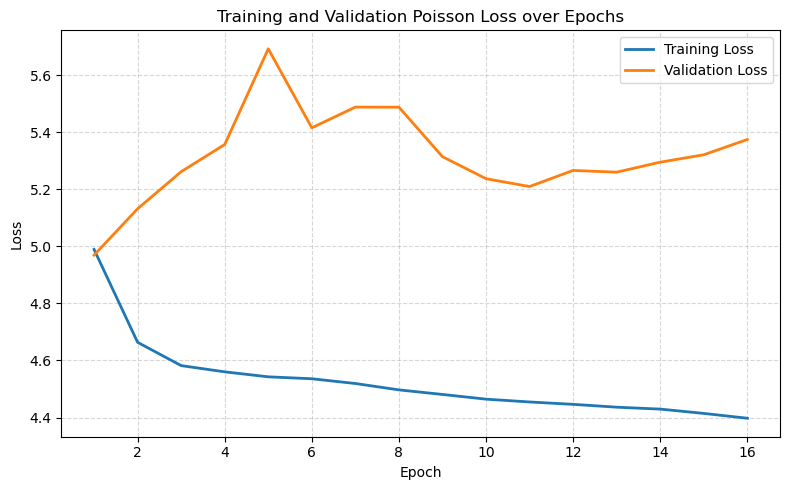

In [29]:
plot_training_history(training_history)


# 8. Most Exciting Input

In [31]:
from neuropixel_predictor.mei.generate import generate_mei

device = 'mps'
neuron_idx = 0
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    model,
    neuron_idx,
    image_shape,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device,
)

print(mei.shape)

RuntimeError: grad can be implicitly created only for scalar outputs